# Experiments on input data scaling, shifting of polynomial centers and lambda parameter sweep

In this notebook we want to build on the findings of "compare_implementations.ipynb" and perform more detailed experiments also with $\lambda \neq 1$.

# Summary of findings

Experiments show that SGD optimization has a "radius of convergence" around the polynomial center.
With $\lambda = 1$ this radius is about ~1.75 to both sides of the polynomial center.
This leaves us with a "usable" x-range of:
- ~1.75 without shifting of polynomial centers in total for all segments
- ~1.75 per segment for shifting mode "left boundary point", since only the right side of radius is usable
- ~3.5 per segment for shifting mode "mean", since both sides of radius are usable

If we take an x interval of [0, 2], as an example, and divide it into two equally sized segments:
- Without shifting polynomial centers, the second polynomial will diverge, since points lie outside the 1.75 radius
- With shifting to the left boundary point, both segments will converge
- With shifting to the mean of the segment, both segments will converge

Adding more optimization targets than just the approximation target decreases the "radius of convergence".
If we add the $C^k$-optimization target:
 - Increasing $k$ of continuity class requirement $C^k$ reduces the "radius of convergence".
   While we can still fit an x interval of [0, 2] divided it into two equally sized segments with $\lambda=0.5$
   shifting to the left boundary point when going for $C^1$-continuity, optimization diverges for $C^2$-continuity.
   This is because gradient magnitudes rise if we increase $k$.
   See next point.
 - Decreasing $\lambda$ decreases the "radius of convergence".
   Decreasing $\lambda$ increases $C^k$ optimization target priority and therefore loss levels and gradient magnitudes.
   With $\lambda = 0.5$, for $C^2$-continuity, the "radius of convergence" is reduced to just under $~1$,
   which makes an x interval of [0, 2] divided it into two equally sized segments diverge
   for shifting to the left boundary point and without shifting.
   However, since shifting to the mean of the segment makes both sides around the polynomial center "available"
   for optimization, it is still able to converge.

Because of these benefits and because shifting to the mean of the segment also shows lower remaining loss levels compared to other shifting methods in our tests,
shifting polynomial centers to the mean of the respective segment is the way to go here.

# Future tests

We have shown in previous experiments, that the AMS optimizer outperforms SGD on optimizing the approximation problem alone.
However, on the other hand, SGD outperforms AMS on optimizing the Ck-discontinuity problem alone.
We can compensate for the SGD optimizer's disadvantage to some extent by initializing with an l2 fit
and then optimizing for the combined "approximation/Ck-discontinity" problem.

 - Test if AMSGrad and SGD perform well with l2 initialization with $1 \dots n$ polynomials
   (Some tests already show that AMSGrad has problems with a "too ideal" initialization with overlap)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import multiprocessing as mp
from itertools import repeat

from tfspline import model
from tfspline import plot
from tfspline import sampledata
from tfspline import parallel

## Input data
To simplify choice of constants we shift and scale data such that values are in the [0, 1] range. Otherwise we would need to adapt learning rate and similar things. We skip the back-transformation as we would do in production code.

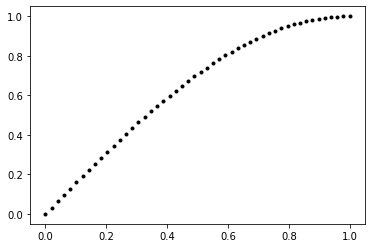

In [2]:
# Generate input data

data_x = np.linspace(0, 0.5*np.pi, 50)
data_y = np.sin(data_x)

# data_x = np.linspace(0, 1, 100)
# data_y = np.sin(data_x**2 * 4 * np.pi)

[data_x_norm, data_y_norm] = sampledata.rescale_input_data(data_x, data_y)

plt.plot(data_x_norm, data_y_norm, 'k.')

## Spline properties based on Stefan Huber's findings in "Polynomial approximation.ipynb"

### Learning rate

0.1

### Gradient regularization

SGD benefits from regularization while adaptive optimizers (Adam) do not.
However, the regularization does not have any negative effect with adaptive optimizers, so we will leave it on in both cases.

### Input data

Number of points: Increasing the number of points to be approximated regulates the convergence. However, the effect is mild.
Noise / shape of input: Does not affect convergence. Since shape and noise does not impair convergence,
we are free to choose an input point cloud resembling a typical rise sequence of a cam profile.

### Optimizers

We limit ourselves to SGD and Adam, as other optimizers fail for high learning rate (0.1) in our application.
SGD: nesterov = true, momentum = 0.95
Adam: amsgrad=True (use default settings beta1 = 0.9, beta2=0.999, epsilon=1e-07)

### Continuity

$C^2$-continuity is sufficient for a wide range of cam applications.
We will therefore go with $C^2$-continuous splines in our tests regarding continuity properties.

In [3]:
learning_rate_adam = 0.1
learning_rate_sgd = 0.1
gradient_regularization=True
epochs=500
deg=5
polynum = 2
continuity_class=2

establish_continuity_at_end_of_optimization = False
l2_init_segment_overlap = 0.4

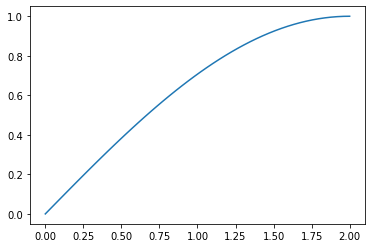

In [4]:
# Rescale x-axis for polynomial count so that every polynomial has interval [0, 1]
#x = data_x_norm
x = polynum * data_x_norm

plt.plot(x, data_y_norm)

## Helper functions

In [5]:
def fit_parallel(x_vals, y_vals, n, params, shift_polynomials='boundary', split=True, initialize_l2=False):
    kwargs = {'data_x': x_vals, 'data_y': y_vals, 'learning_rate': learning_rate_adam, 'degree': deg, 'polynum': n, 'ck': continuity_class,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': gradient_regularization, 'continuity': establish_continuity_at_end_of_optimization,
        'initialize_l2_fit': initialize_l2, 'seg_overlap': l2_init_segment_overlap, 'shift_polynomial_centers': shift_polynomials, 'split_uniform': split,
          'mode': 'approx_ck'}

    pool1 = mp.Pool(mp.cpu_count())
    results_adam = pool1.starmap(parallel.job, zip(params, repeat(kwargs)))

    kwargs = {'data_x': x_vals, 'data_y': y_vals, 'learning_rate': learning_rate_sgd, 'degree': deg, 'polynum': polynum, 'ck': continuity_class,
            'optimizer': 'SGD', 'n_epochs': epochs, 'gradient_regularization': gradient_regularization, 'continuity': establish_continuity_at_end_of_optimization,
            'initialize_l2_fit': initialize_l2, 'seg_overlap': l2_init_segment_overlap, 'shift_polynomial_centers': shift_polynomials, 'split_uniform': split,
              'mode': 'approx_ck'}

    pool2 = mp.Pool(mp.cpu_count())
    results_sgd = pool2.starmap(parallel.job, zip(params, repeat(kwargs)))

    return results_sgd, results_adam

def get_spline_result_from_parallel_fit(x_vals, y_vals, results_sgd, results_adam, params, shift_polynomials='boundary', split=True):
    '''Get and return splines from result and print minimum losses'''
    splines_sgd = []
    splines_adam = []
    min_loss_approx = [1, np.inf, 'SGD']
    min_loss_ck = [1, np.inf, 'SGD']
    min_loss_total = [1, np.inf, 'SGD']

    for i, (spline_s, spline_a) in enumerate(zip(results_sgd, results_adam)):
        spline_s = model.get_spline_from_coeffs(results_sgd[i][2], x_vals, y_vals, total_loss_values=results_sgd[i][1][0], e_loss_values=results_sgd[i][1][1],
                                                        uniform_split=split, shift_polynomial_centers=shift_polynomials)
        splines_sgd.append(spline_s)

        spline_a = (model.get_spline_from_coeffs(results_adam[i][2], x_vals, y_vals, total_loss_values=results_adam[i][1][0], e_loss_values=results_adam[i][1][1],
                                                          uniform_split=split, shift_polynomial_centers=shift_polynomials))
        splines_adam.append(spline_a)

        if spline_s.total_loss_values[-1] < min_loss_total[1]:
            min_loss_total[2] = 'SGD'
            min_loss_total[1] = spline_s.total_loss_values[-1]
            min_loss_total[0] = i
        if spline_a.total_loss_values[-1] < min_loss_total[1]:
            min_loss_total[2] = 'AMSGrad'
            min_loss_total[1] = spline_a.total_loss_values[-1]
            min_loss_total[0] = i

        if spline_s.e_loss_values[-1] < min_loss_approx[1]:
            min_loss_approx[2] = 'SGD'
            min_loss_approx[1] = spline_s.e_loss_values[-1]
            min_loss_approx[0] = i
        if spline_a.e_loss_values[-1] < min_loss_total[1]:
            min_loss_approx[2] = 'AMSGrad'
            min_loss_approx[1] = spline_a.e_loss_values[-1]
            min_loss_approx[0] = i

        if spline_s.ck_pressure()[0] < min_loss_ck[1]:
            min_loss_ck[2] = 'SGD'
            min_loss_ck[1] = spline_s.ck_pressure()[0]
            min_loss_ck[0] = i
        if spline_a.ck_pressure()[0] < min_loss_ck[1]:
            min_loss_ck[2] = 'AMSGrad'
            min_loss_ck[1] = spline_a.ck_pressure()[0]
            min_loss_ck[0] = i

    print(f'Lowest remaining approximation loss ({min_loss_approx[1]}) achieved by optimizer {min_loss_approx[2]} at lambda = {params[min_loss_approx[0]]}')
    print(f'Lowest remaining Ck-pressure loss ({min_loss_ck[1]}) achieved by optimizer {min_loss_ck[2]} at lambda = {params[min_loss_ck[0]]}')
    print(f'Lowest remaining total loss ({min_loss_total[1]}) achieved by optimizer {min_loss_total[2]} at lambda = {params[min_loss_total[0]]}')

    return splines_sgd, splines_adam


def plot_spline_comparisons(splines_sgd, splines_adam, xss):
    for i, (spline_s, spline_a) in enumerate(zip(splines_sgd, splines_adam)):
        fig = plot.plot_spline_comparison(spline_s, spline_a, xss, spline_1_name='SGD', spline_2_name='AMSGrad', title=f'Lambda = {params[i]}')

def fit_and_plot_optimizer_results(x, y, lambd=1, p_num=1, ep=500, initialize_l2_fit=False, overlap_segments=0.4,
                                 shift_polynomial_centers='boundary', split_uniform='True', plot_result=True, title='', AMSGrad=True, SGD=True, ck=continuity_class):
    ck_factor = 1 - lambd
    approx_factor = lambd
    opt_sgd = keras.optimizers.SGD(learning_rate=learning_rate_sgd, momentum=0.95, nesterov=True)
    opt_ams = keras.optimizers.Adam(learning_rate=learning_rate_adam, amsgrad=True)

    if not AMSGrad and not SGD:
        return

    if AMSGrad:
        spline_adam = model.Spline(polydegree=deg, polynum=p_num, ck=ck)
        spline_adam.continuity = False
        spline_adam.verbose = True

        spline_adam.fit(x, y, optimizer=opt_ams, n_epochs=ep, factor_approximation_quality=approx_factor,
        factor_ck_pressure=ck_factor, factor_curvature=0, gradient_regularization=gradient_regularization, overlap_segments=overlap_segments,
                        shift_polynomial_centers=shift_polynomial_centers, uniform_split=split_uniform, initialize_l2fit=initialize_l2_fit)

    if SGD:
        spline_sgd = model.Spline(polydegree=deg, polynum=p_num, ck=ck)
        spline_sgd.continuity = False
        spline_sgd.verbose = True

        spline_sgd.fit(x, y, optimizer=opt_sgd, n_epochs=ep, factor_approximation_quality=approx_factor,
        factor_ck_pressure=ck_factor, factor_curvature=0, gradient_regularization=gradient_regularization, overlap_segments=overlap_segments,
                       shift_polynomial_centers=shift_polynomial_centers, uniform_split=split_uniform, initialize_l2fit=initialize_l2_fit)

    if plot_result and AMSGrad and SGD:
        plot.plot_spline_comparison(spline_sgd, spline_adam, np.linspace(x[0], x[-1], 1000), spline_1_name='SGD', spline_2_name='AMSGrad', title=title)

    if SGD:
        return spline_sgd
    elif AMSGrad:
        return spline_adam

def plot_loss_for_different_x_input_ranges(x_step=np.arange(1, 3, 0.25), title='', n=1, AMSGrad=False, lambd=1, ck=continuity_class):
    splines_sgd_boundary = []
    splines_sgd_mean = []
    splines_sgd_off = []

    for i in x_step:
        splines_sgd_boundary.append(fit_and_plot_optimizer_results(i * data_x_norm, data_y_norm, lambd=lambd, p_num=n, ep=500, initialize_l2_fit=False, overlap_segments=0.4,
                                                                   shift_polynomial_centers='boundary', split_uniform='True', plot_result=False, AMSGrad=AMSGrad, SGD=not AMSGrad, ck=ck))
        splines_sgd_mean.append(fit_and_plot_optimizer_results(i * data_x_norm, data_y_norm, lambd=lambd, p_num=n, ep=500, initialize_l2_fit=False, overlap_segments=0.4,
                                                               shift_polynomial_centers='mean', split_uniform='True', plot_result=False, AMSGrad=AMSGrad, SGD=not AMSGrad, ck=ck))
        splines_sgd_off.append(fit_and_plot_optimizer_results(i * data_x_norm, data_y_norm, lambd=lambd, p_num=n, ep=500, initialize_l2_fit=False, overlap_segments=0.4,
                                                              shift_polynomial_centers='off', split_uniform='True', plot_result=False, AMSGrad=AMSGrad, SGD=not AMSGrad, ck=ck))

    fig, fig_axes = plt.subplots(1, 3, constrained_layout=True)
    fig.set_figwidth(18)
    fig.set_figheight(5)

    fig.suptitle(title)

    for i in range(3):
        for j in range(len(x_step)):
            if i == 0:
                fig_axes[i].semilogy(splines_sgd_boundary[j].total_loss_values, label=f'$x-max = {x_step[j]}')
                fig_axes[i].set_title("Loss - Shifting mode: Left boundary point")
                fig_axes[i].set_ylim((10**-6,10**0))
            if i == 1:
                fig_axes[i].semilogy(splines_sgd_mean[j].total_loss_values, label=f'$x-max = {x_step[j]}')
                fig_axes[i].set_title("Loss - Shifting mode: Segment mean")
                fig_axes[i].set_ylim((10**-6,10**0))
            if i == 2:
                fig_axes[i].semilogy(splines_sgd_off[j].total_loss_values, label=f'$x-max = {x_step[j]}')
                fig_axes[i].set_title("Loss - Shifting mode: No shifting")
                fig_axes[i].set_ylim((10**-6,10**0))

        fig_axes[i].legend(loc="best")
        fig_axes[i].set_xlabel("Epochs")

## Convergence for increasing x input range - First tests
In this experiment we raise x-input interval range for 1 polynomial and $\lambda = 1$ - When does result diverge for SGD?
(As seen in "compare_implementations.ipynb", we can expect AMSGrad to converge).
Then, we repeat the test for 2 polynomials.

TensorFlow: Number of recognized GPUs:  0
Fitting took 3.4505019187927246 secondsoss=0.000353592epoch=410, loss=0.000288586epoch=450, loss=0.000233576epoch=490, loss=0.000187602
TensorFlow: Number of recognized GPUs:  0
Fitting took 2.9470481872558594 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.2543785572052 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 2.9992802143096924 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.1264538764953613 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.0381503105163574 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.122122287750244 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.0110936164855957 seconds
TensorFlow: Number of recognized GPUs:  0
=30, loss=0.019438epoch=70, loss=0.00365512epoch=100, loss=0.00252583epoch=140, loss=0.00189854epoch=180, loss=0.00139691epoch=220, loss=0.000994909epoch=260, loss=0.000689587epoch=300, loss=0.000467576epoch=34

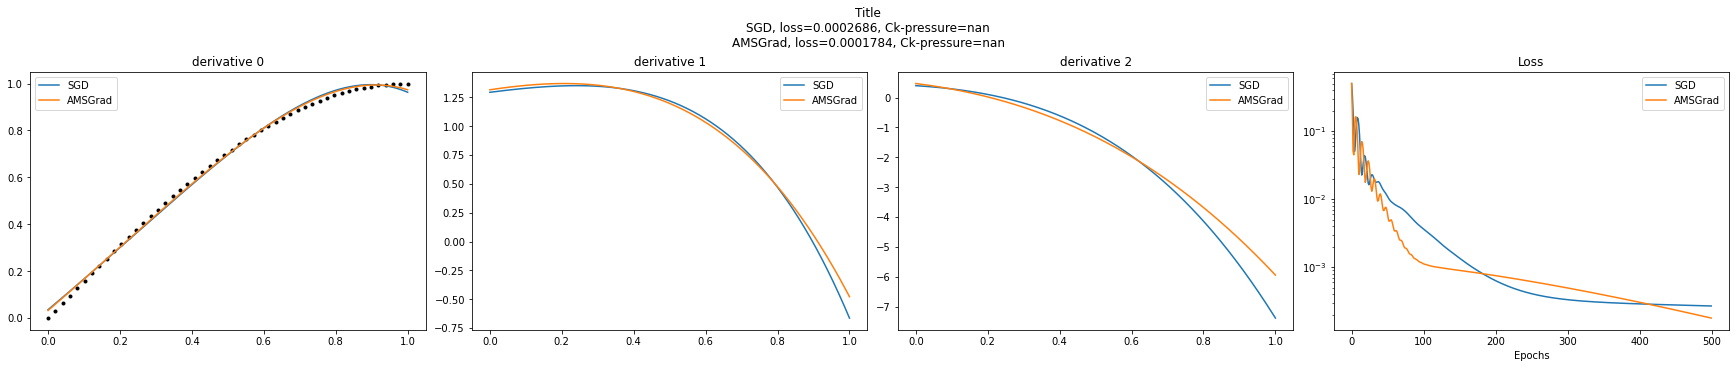

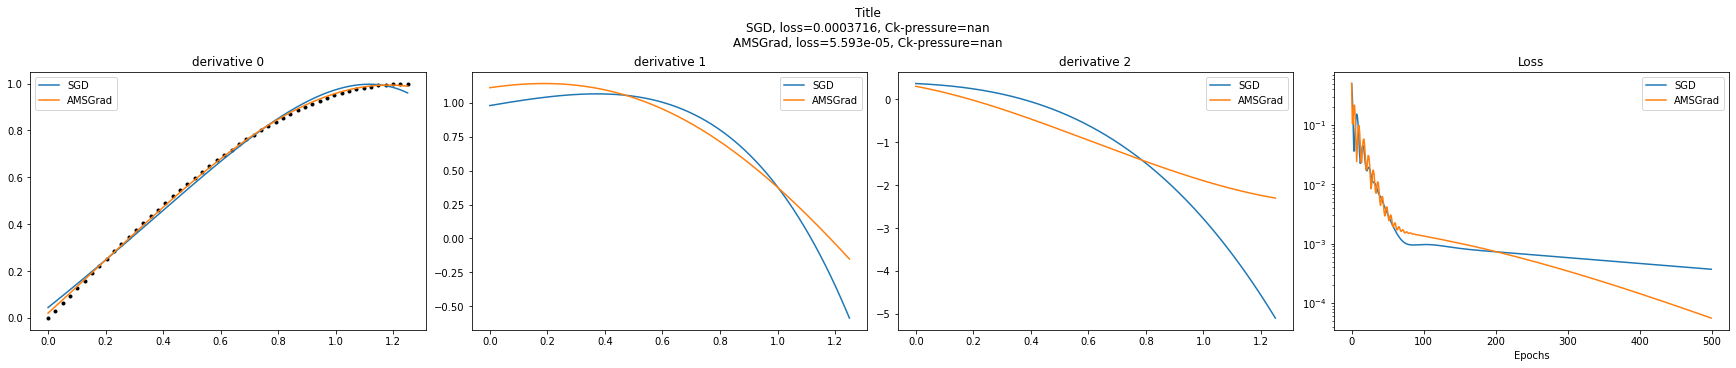

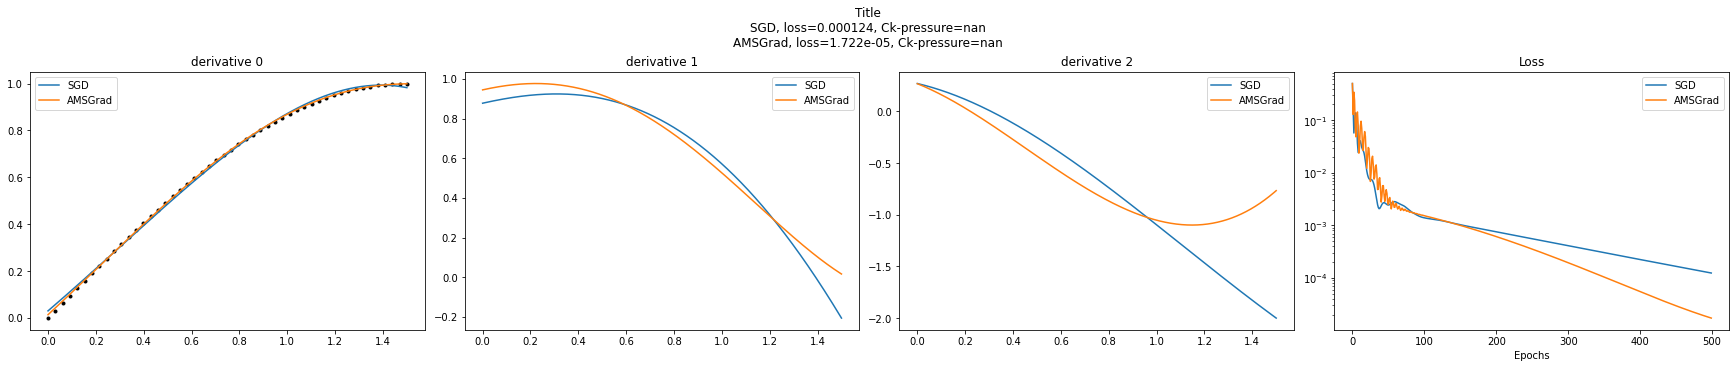

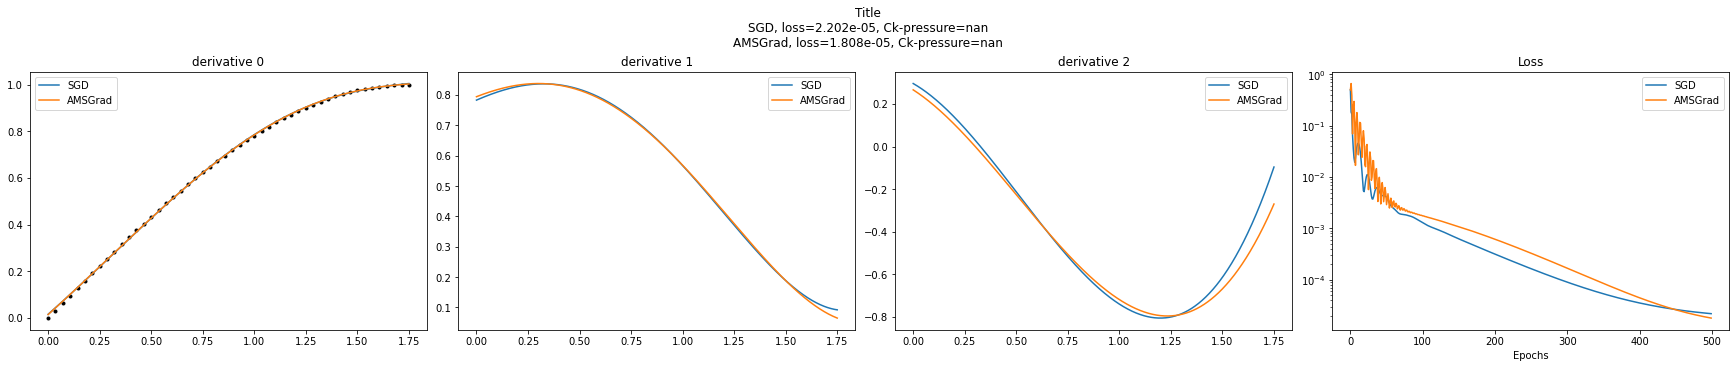

c:\users\pc\documents\fh\ki-net git\mloptimizedcam\venv\lib\site-packages\numpy\ma\core.py:6852: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


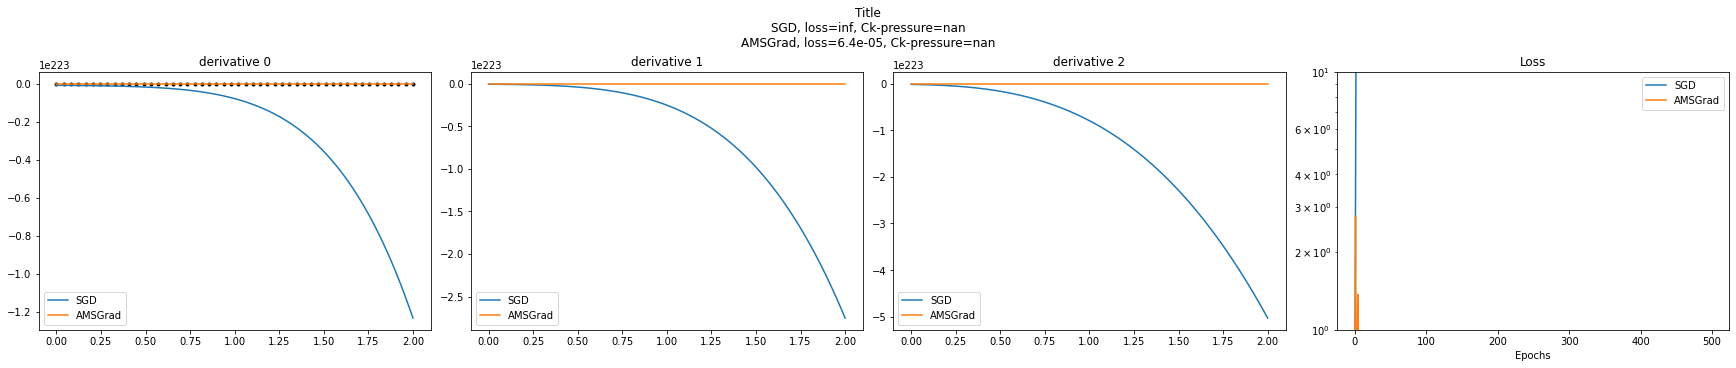

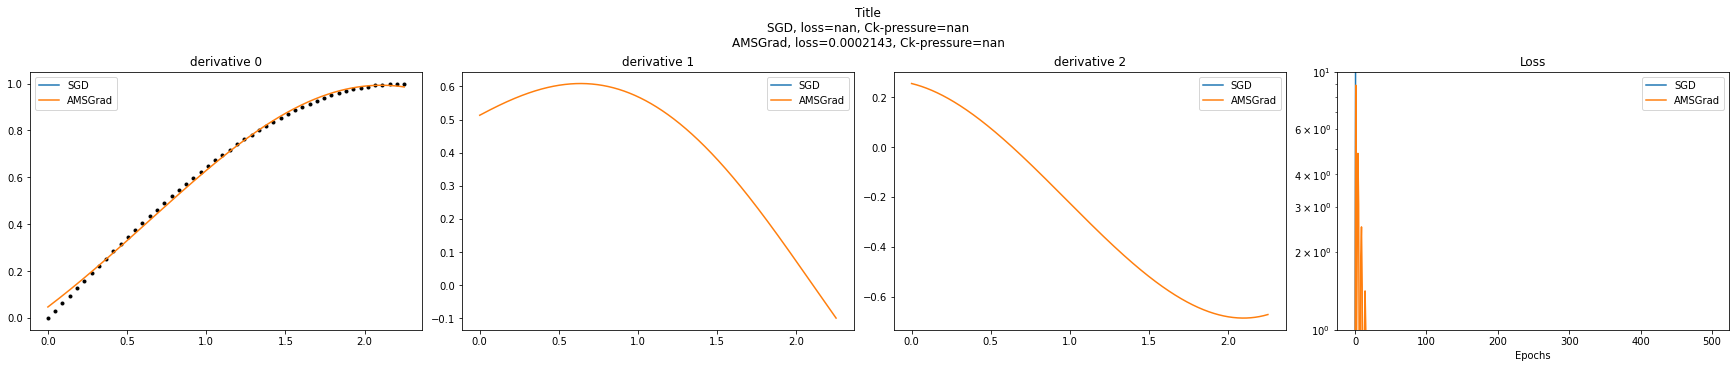

In [13]:
for i in np.arange(1, 2.5, 0.25):
    fit_and_plot_optimizer_results(i * data_x_norm, data_y_norm, lambd=1, p_num=1, ep=500, initialize_l2_fit=False, overlap_segments=0.4,
                                 shift_polynomial_centers='boundary', split_uniform='True')

### Discussion

While fitting a range of [0, 1.75] is still possible for SGD, the result diverges for intervals greater than that.
We achieve the best approximation result at the greatest possible interval.
This is expected, since the x-values increase and, due to the nature of the polynomial construction algorithm, therefore also the "learning signal" increases.
Let's now look at the behaviour with 2 polynomials.

TensorFlow: Number of recognized GPUs:  0
Fitting took 5.561453580856323 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.319931268692017 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.405974626541138 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.226449489593506 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.4413745403289795 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.274970769882202 seconds
TensorFlow: Number of recognized GPUs:  0
poch=180, loss=0.000152313epoch=210, loss=0.000117405epoch=230, loss=9.80496e-05epoch=250, loss=8.1547e-05epoch=280, loss=6.1505e-05epoch=300, loss=5.08432e-05epoch=320, loss=4.19989e-05epoch=350, loss=3.1556e-05epoch=370, loss=2.61315e-05epoch=400, loss=1.97993e-05epoch=420, loss=1.65392e-05epoch=440, loss=1.38882e-05epoch=470, loss=1.08146e-05Fitting took 5.509838581085205 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 4.981622219085693 seconds
Tens

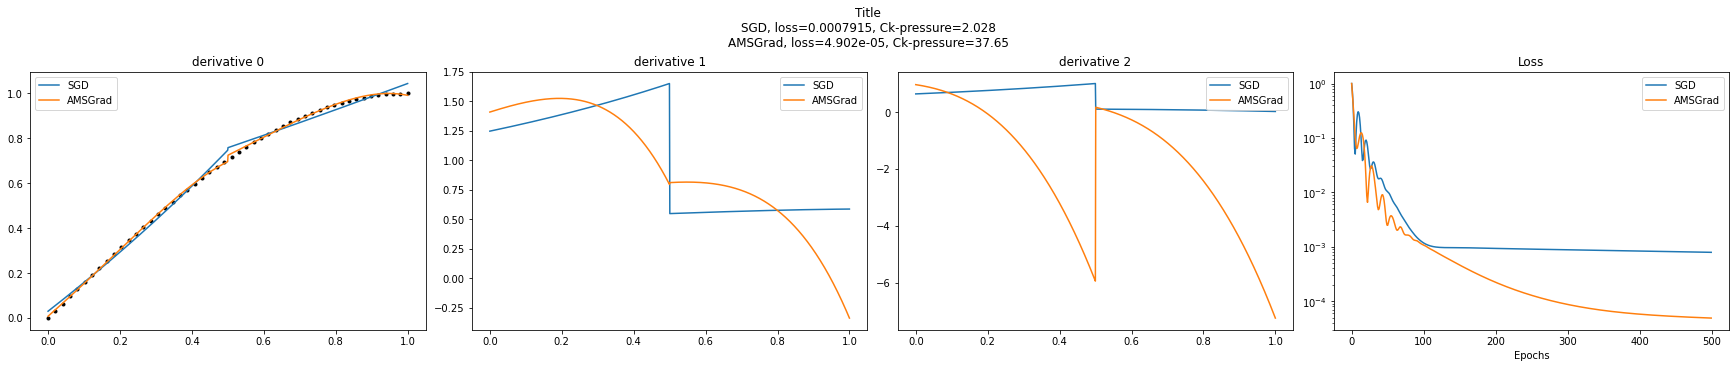

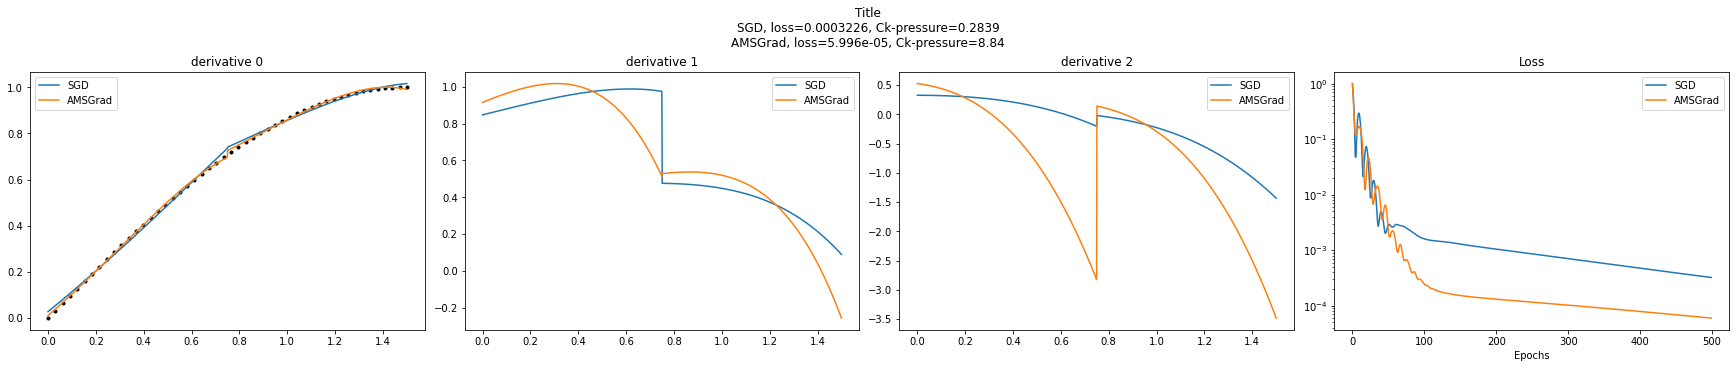

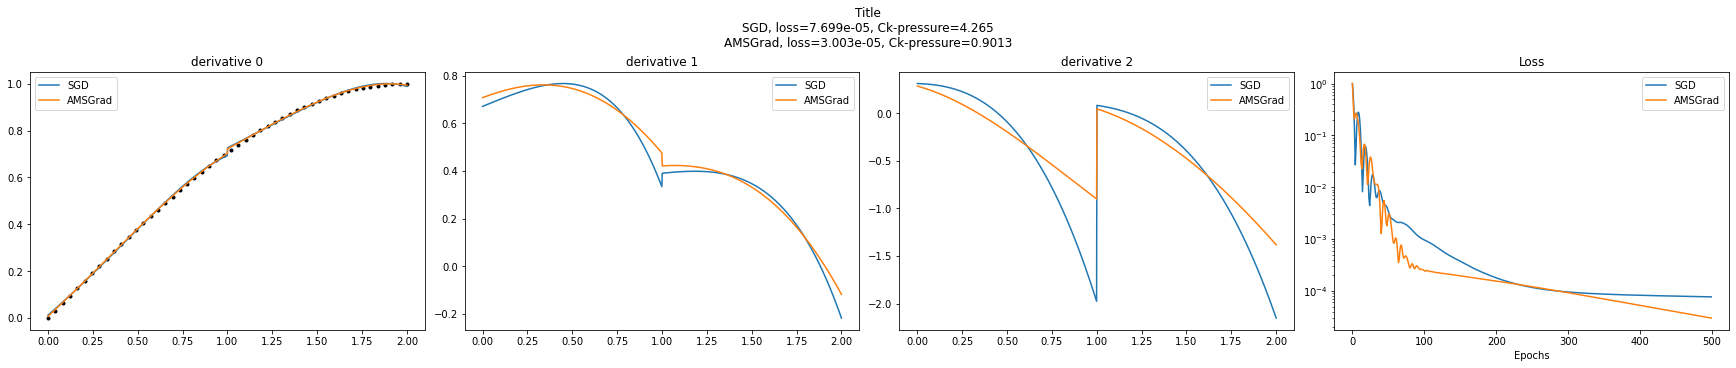

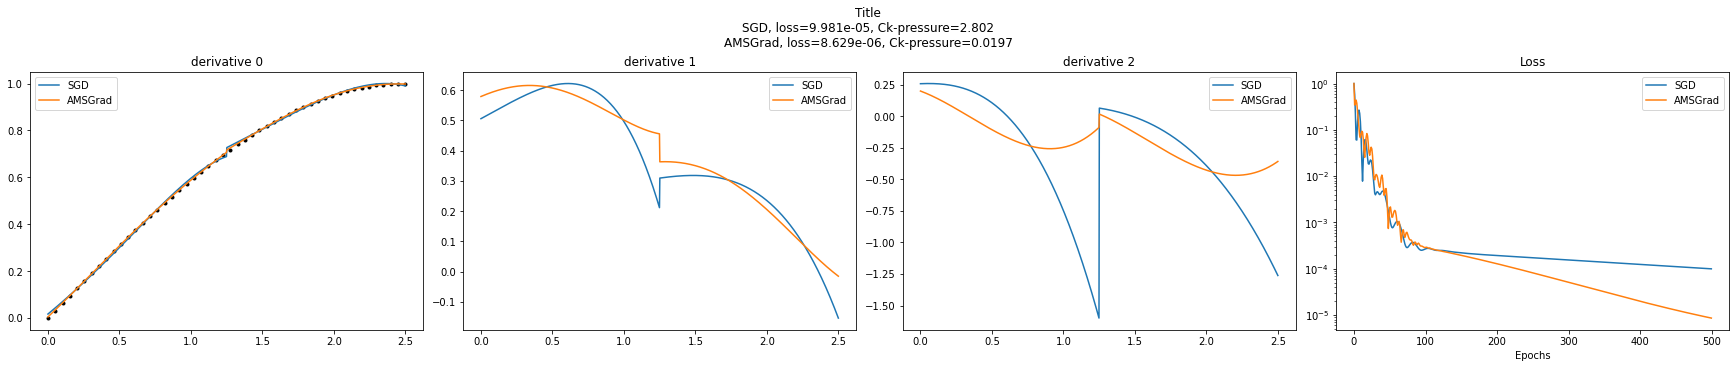

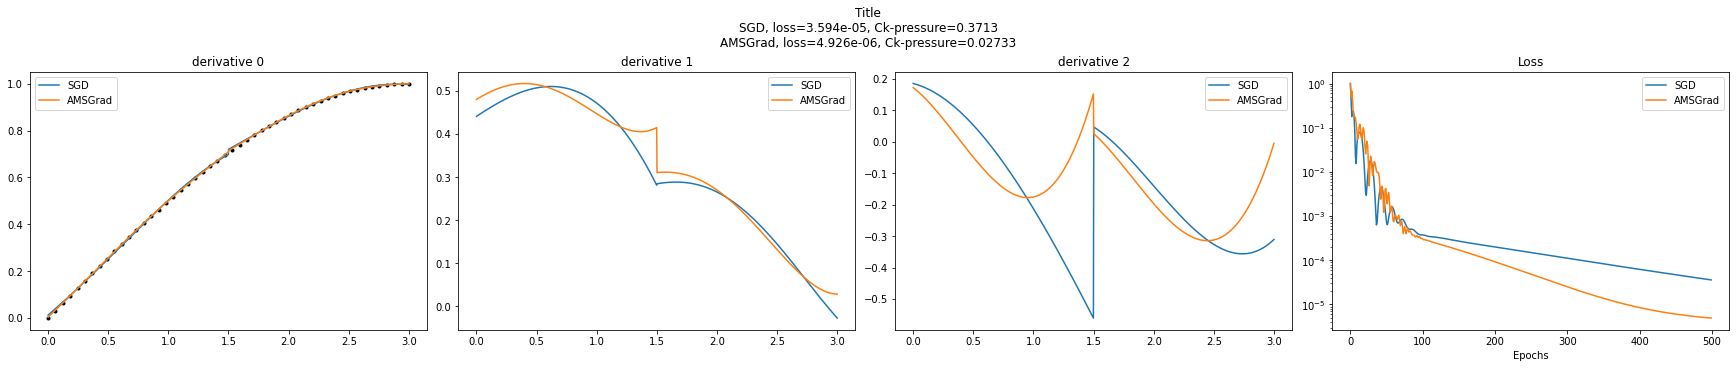

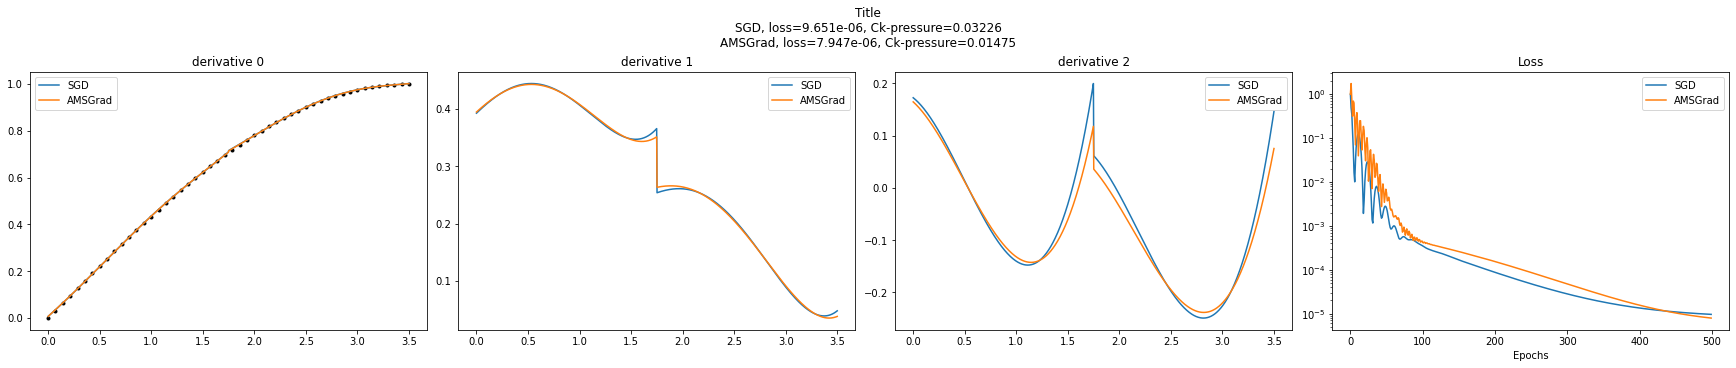

c:\users\pc\documents\fh\ki-net git\mloptimizedcam\venv\lib\site-packages\numpy\ma\core.py:6852: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


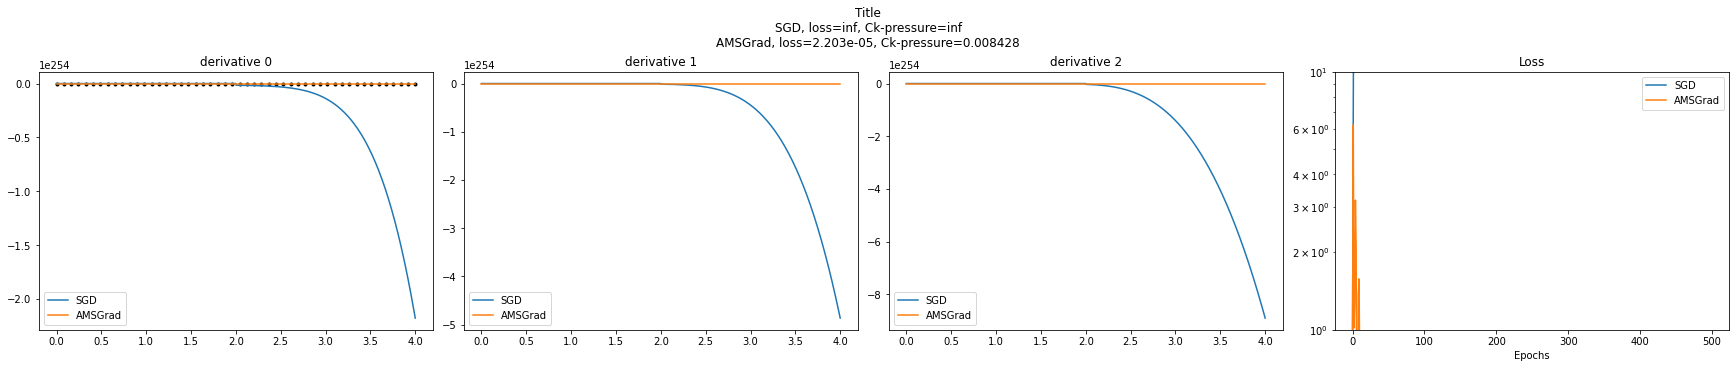

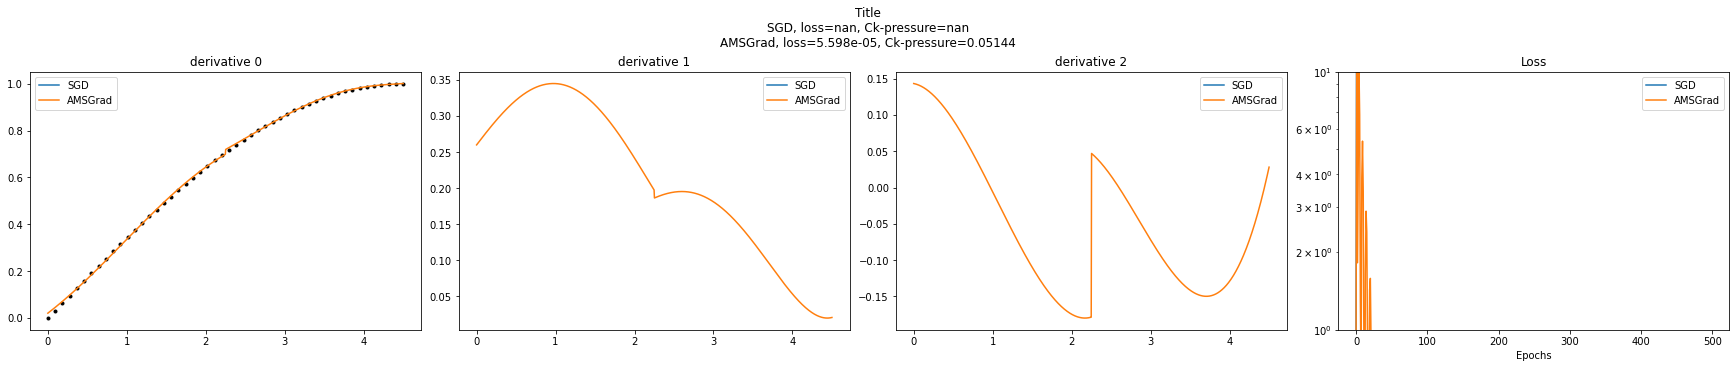

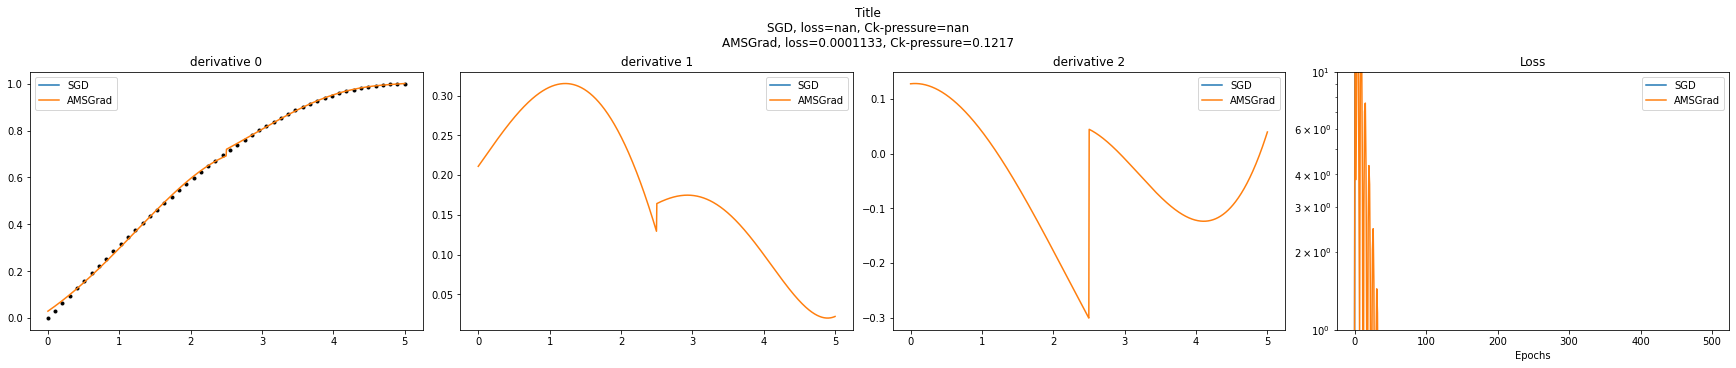

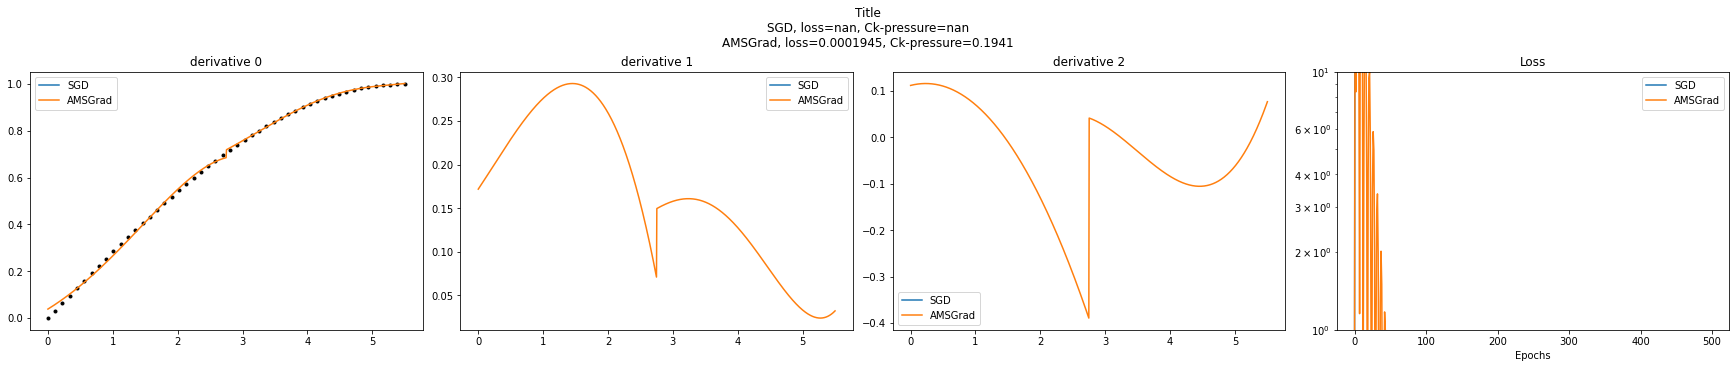

In [16]:
for i in np.arange(1, 5, 0.5):
    fit_and_plot_optimizer_results(i * data_x_norm, data_y_norm, lambd=1, p_num=2, ep=500, initialize_l2_fit=False, overlap_segments=0.4,
                                 shift_polynomial_centers='boundary', split_uniform='True')

### Discussion

Also with 2 polynomials, the result for SGD diverges if the range of an individual segment exceeds [0, 1.75].
If we turn shifting off, the result diverges earlier.

TensorFlow: Number of recognized GPUs:  0
Fitting took 5.6669957637786865 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.429002523422241 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.521526336669922 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.373000144958496 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.576149940490723 secondsloss=5.9896e-05epoch=410, loss=5.72094e-05epoch=430, loss=5.46827e-05epoch=460, loss=5.11846e-05epoch=480, loss=4.90403e-05
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.271005153656006 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.56706690788269 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.297001361846924 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.574000597000122 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.160000562667847 seconds loss= infepoch=230, loss= infepoch=260, loss= infepoch=290, loss= i

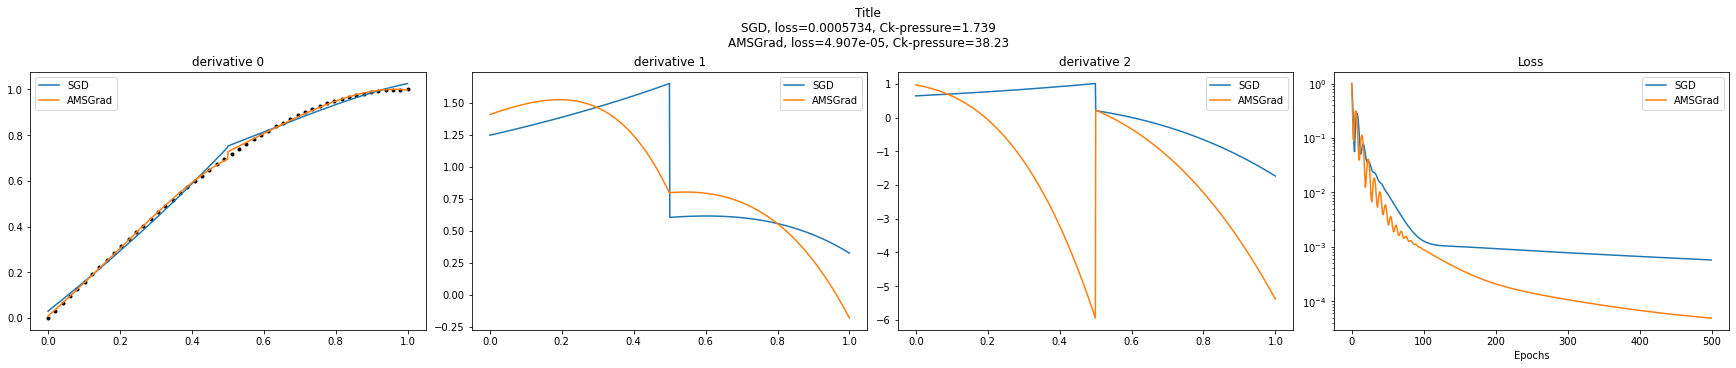

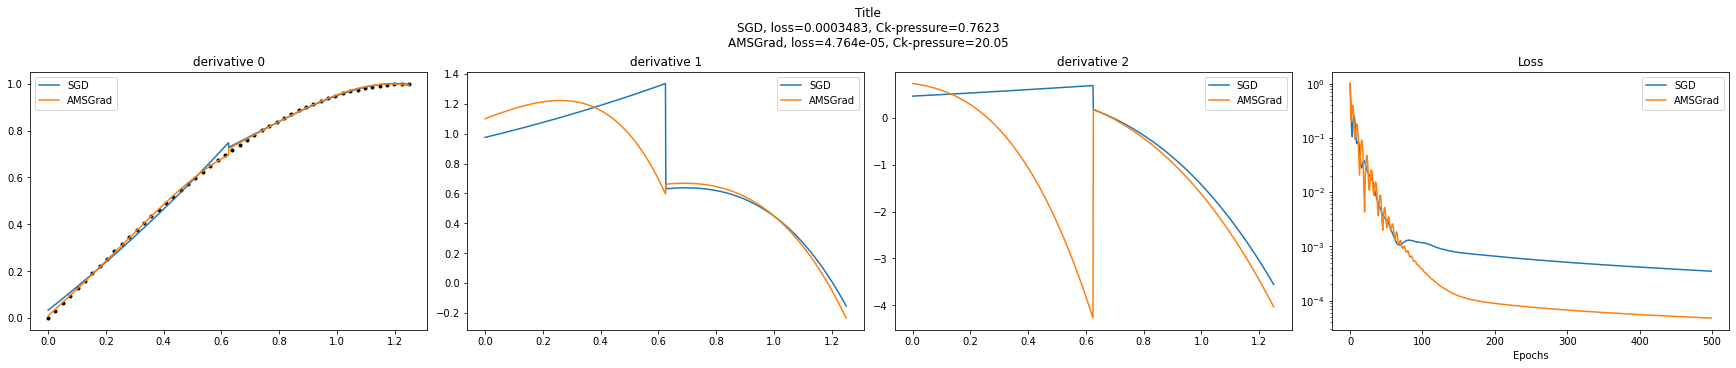

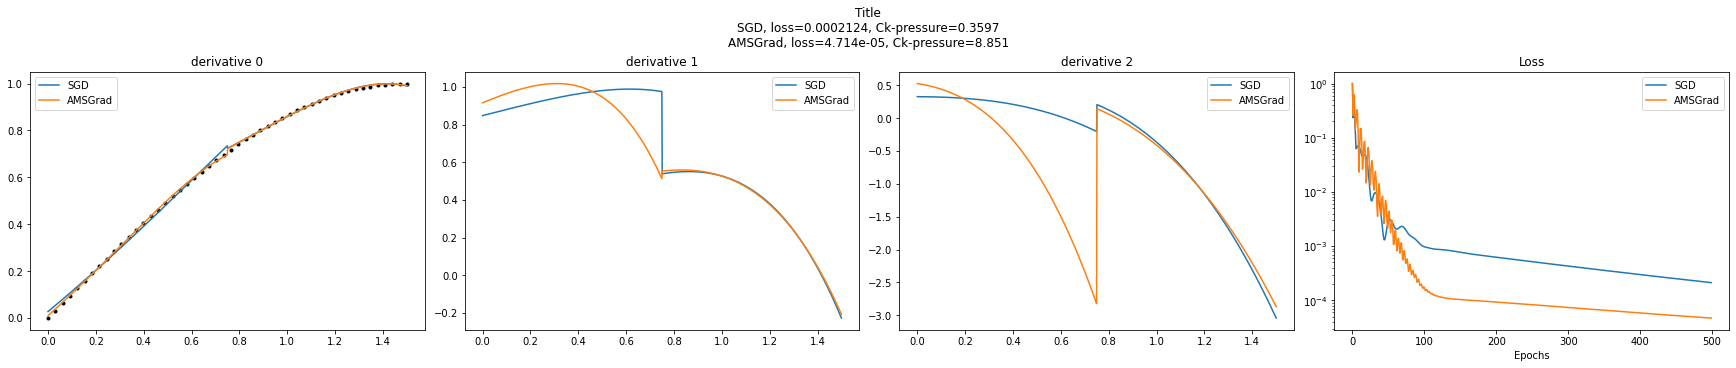

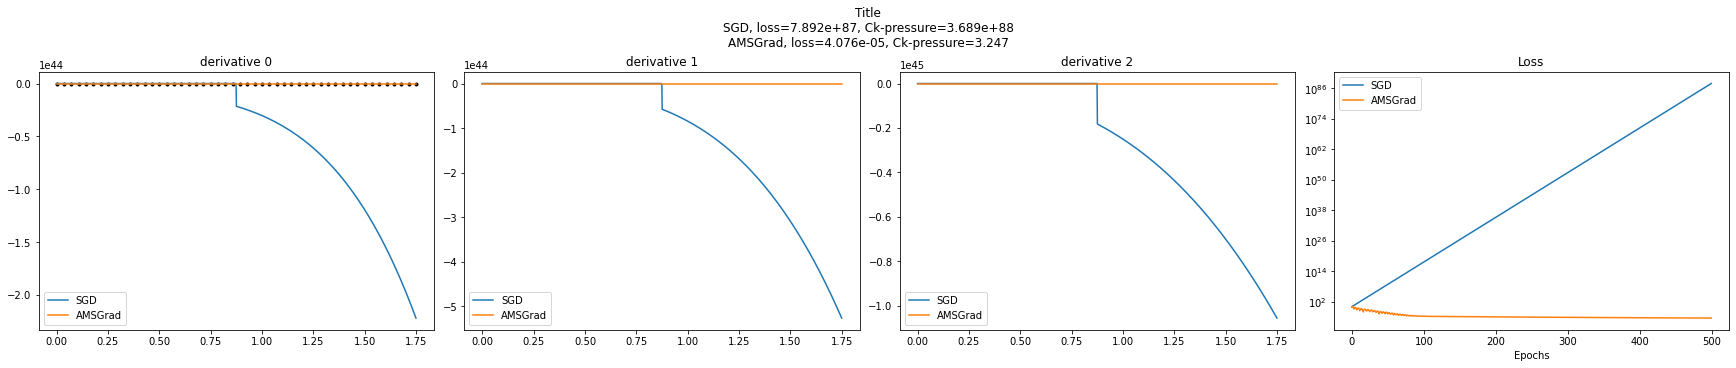

c:\users\pc\documents\fh\ki-net git\mloptimizedcam\venv\lib\site-packages\numpy\ma\core.py:6852: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


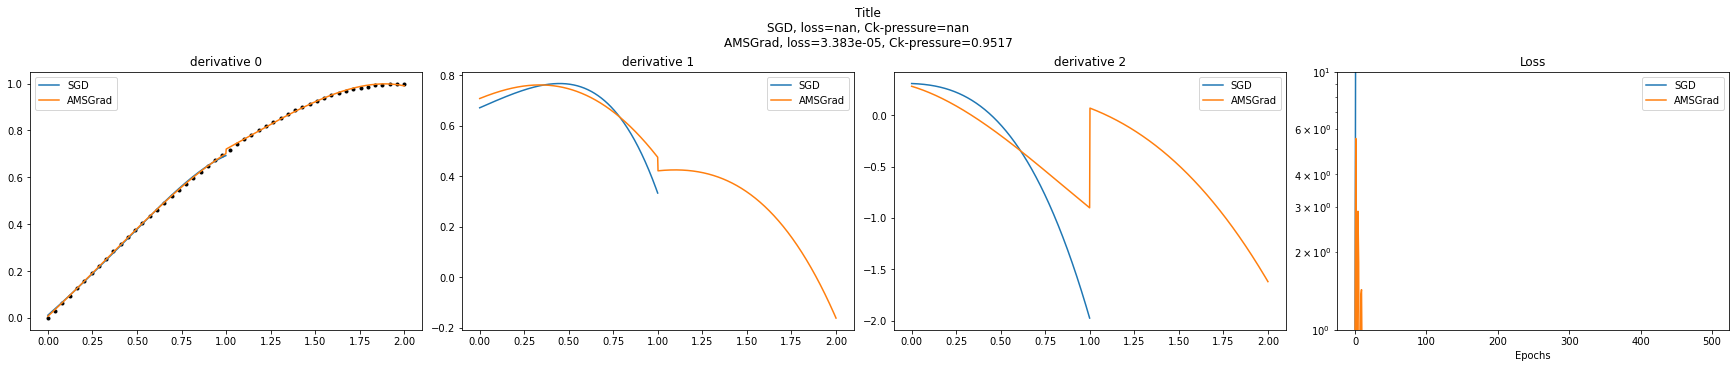

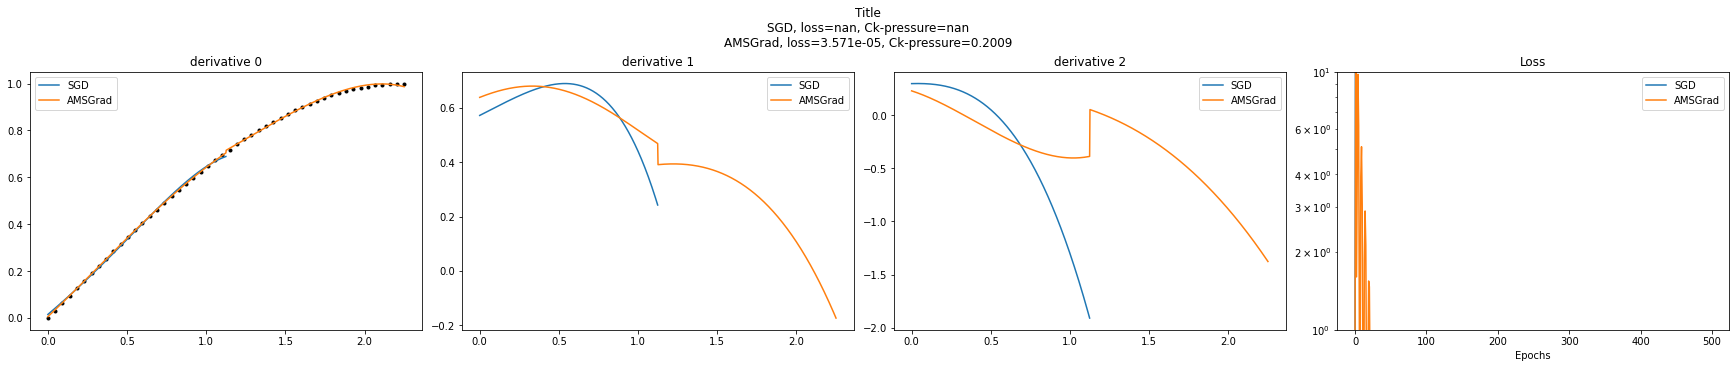

In [17]:
for i in np.arange(1, 2, 0.25):
    fit_and_plot_optimizer_results(i * data_x_norm, data_y_norm, lambd=1, p_num=2, ep=500, initialize_l2_fit=False, overlap_segments=0.4,
                                 shift_polynomial_centers='off', split_uniform='True')

### Discussion

With shifting of polynomial centers turned off, fitting of the second polynomial segment diverges at a range of [0, 1.75].
With 1 polynomial, SGD was still able to converge at this interval range.
Let's now take a look at shifting of polynomial centers to the mean of the interval.

TensorFlow: Number of recognized GPUs:  0
Fitting took 3.3428666591644287 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 2.9410979747772217 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.374091625213623 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.1625144481658936 secondsoss=2.68977e-05epoch=390, loss=2.4177e-05epoch=430, loss=2.17606e-05epoch=470, loss=1.96136e-05
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.573061466217041 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.0141396522521973 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.28513240814209 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.154078483581543 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.2570676803588867 secondsoss=1.11505e-10epoch=480, loss=3.341e-11
TensorFlow: Number of recognized GPUs:  0
Fitting took 2.937091112136841 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting t

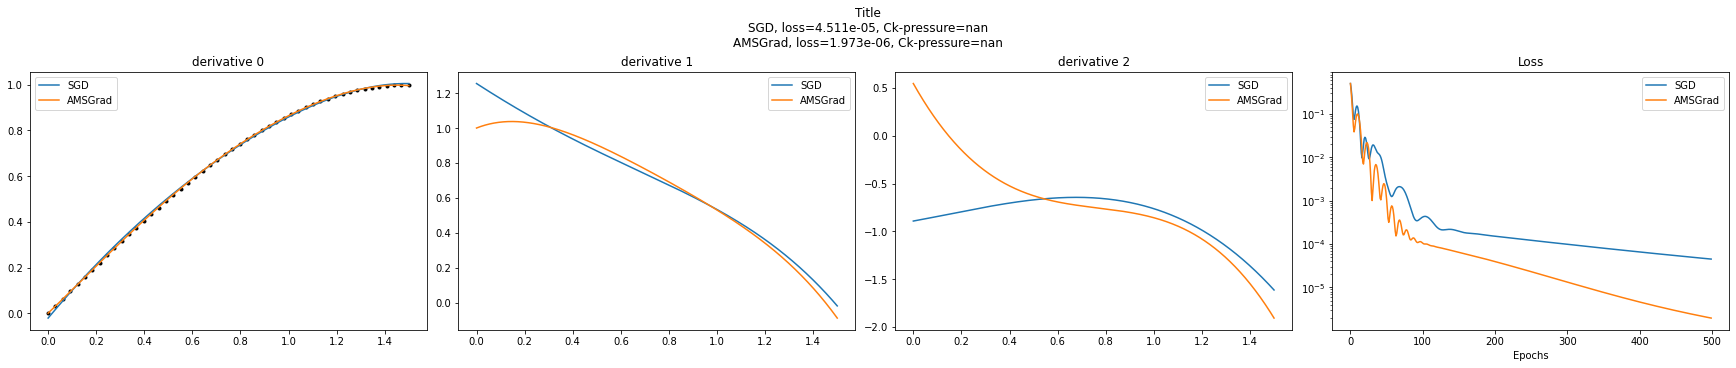

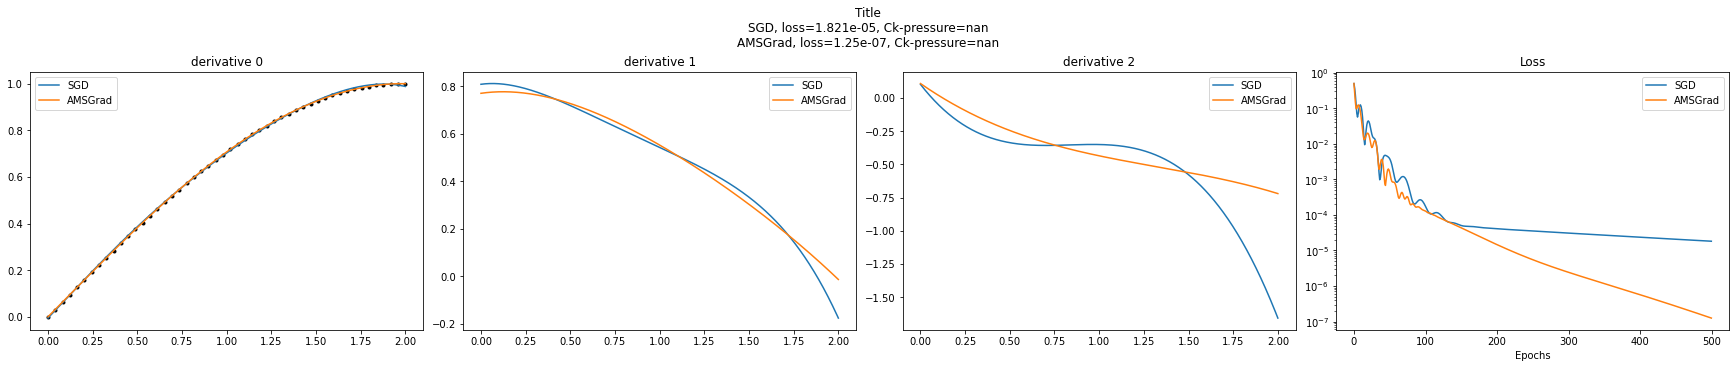

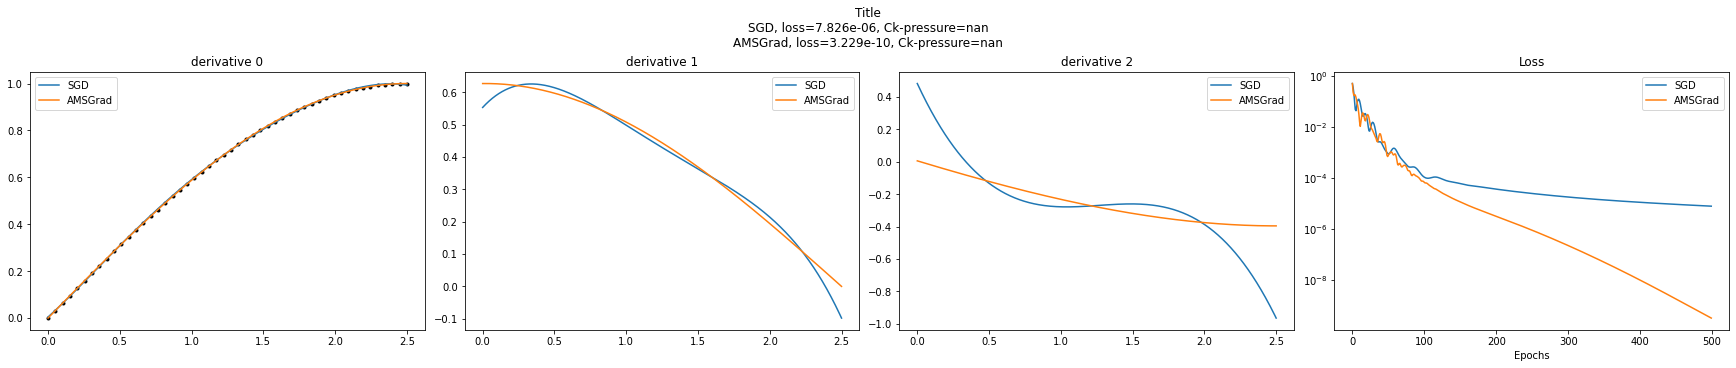

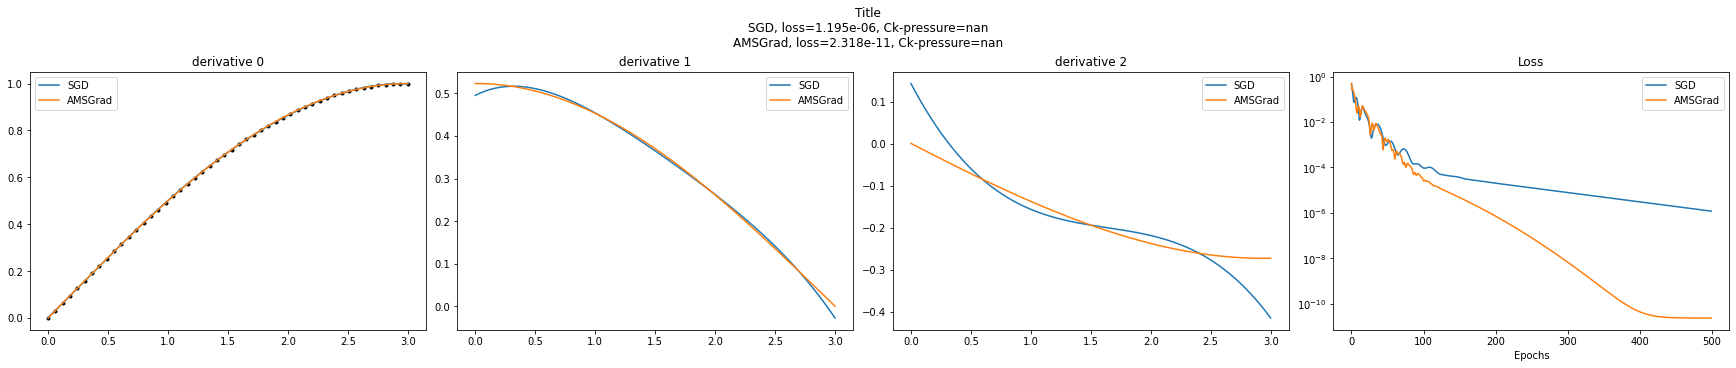

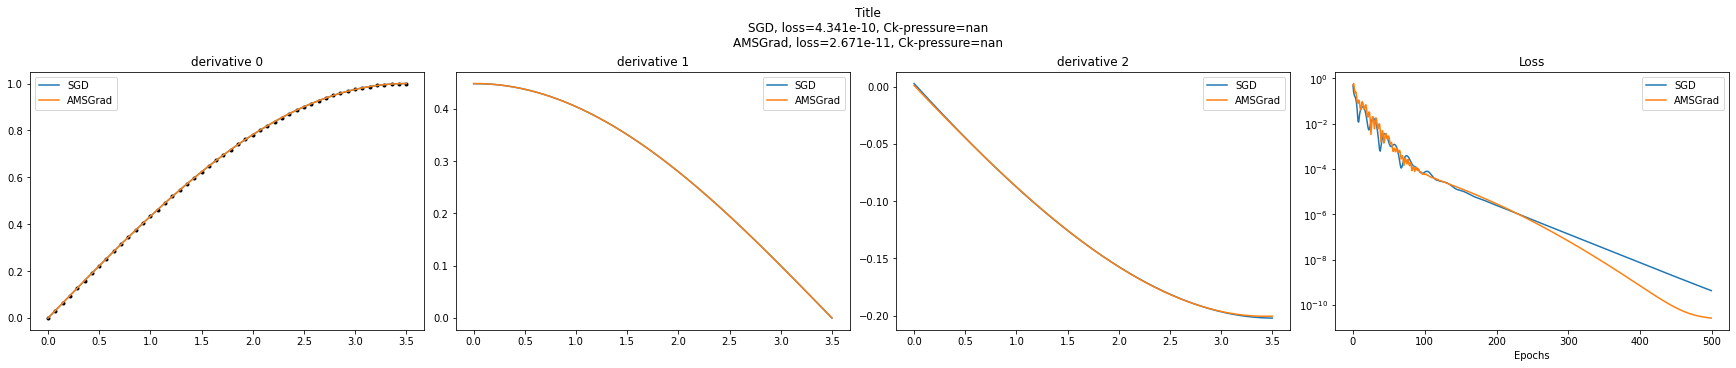

c:\users\pc\documents\fh\ki-net git\mloptimizedcam\venv\lib\site-packages\matplotlib\ticker.py:2377: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades
c:\users\pc\documents\fh\ki-net git\mloptimizedcam\venv\lib\site-packages\matplotlib\ticker.py:2207: RuntimeWarning: invalid value encountered in double_scalars
  return abs(x - np.round(x)) < atol
c:\users\pc\documents\fh\ki-net git\mloptimizedcam\venv\lib\site-packages\matplotlib\ticker.py:1077: RuntimeWarning: invalid value encountered in double_scalars
  coeff = round(b ** (fx - exponent))


ValueError: cannot convert float NaN to integer

<Figure size 1728x360 with 4 Axes>

c:\users\pc\documents\fh\ki-net git\mloptimizedcam\venv\lib\site-packages\numpy\ma\core.py:6852: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


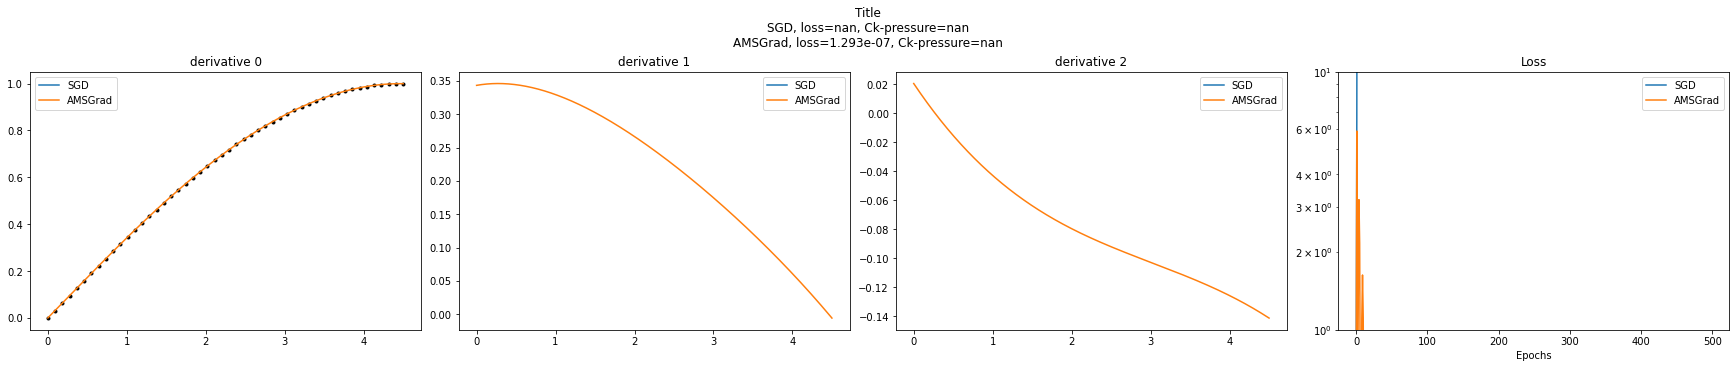

In [19]:
for i in np.arange(1.5, 5, 0.5):
    fit_and_plot_optimizer_results(i * data_x_norm, data_y_norm, lambd=1, p_num=1, ep=500, initialize_l2_fit=False, overlap_segments=0.4,
                                 shift_polynomial_centers='mean', split_uniform='True')

### Discussion

Shifting the polynomial center to the mean of the segment, the result diverges after interval [0, 3.5].
This is double the range we can achieve compared to shifting to the left boundary point of the interval.
This makes sense, as the optimization routine seems to be able to fit up to an x-range of [0, 1.75] to both sides of the center.

TensorFlow: Number of recognized GPUs:  0
Fitting took 5.72400164604187 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.501108407974243 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.609090805053711 seconds
TensorFlow: Number of recognized GPUs:  0
poch=370, loss=2.6696e-12epoch=390, loss=7.971e-13epoch=420, loss=7.43867e-13epoch=440, loss=2.67872e-13epoch=470, loss=5.25077e-14Fitting took 5.386586666107178 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.5920569896698 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.375000953674316 seconds


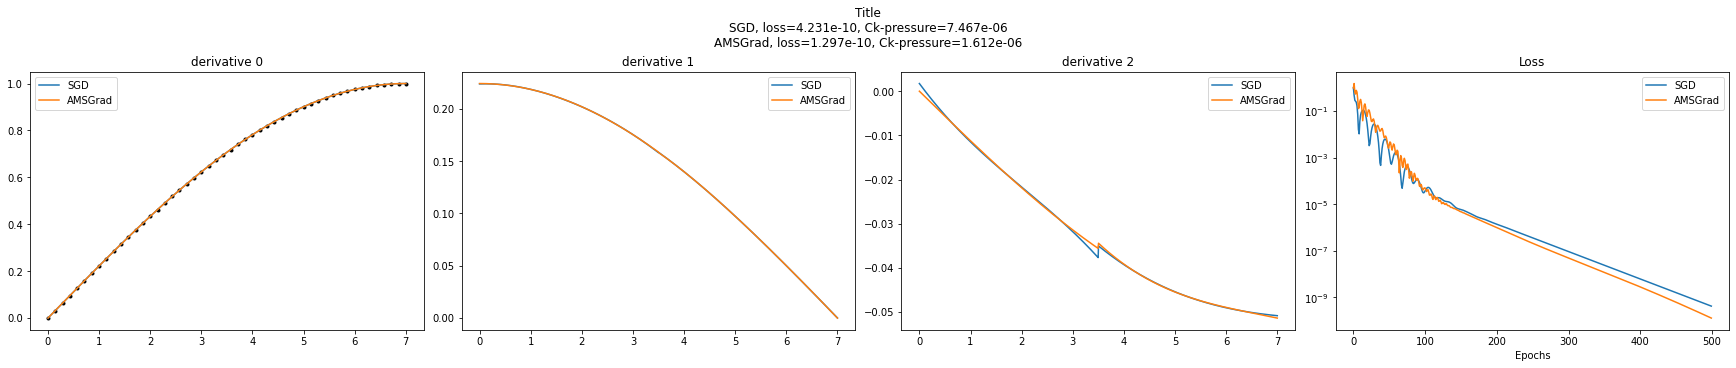

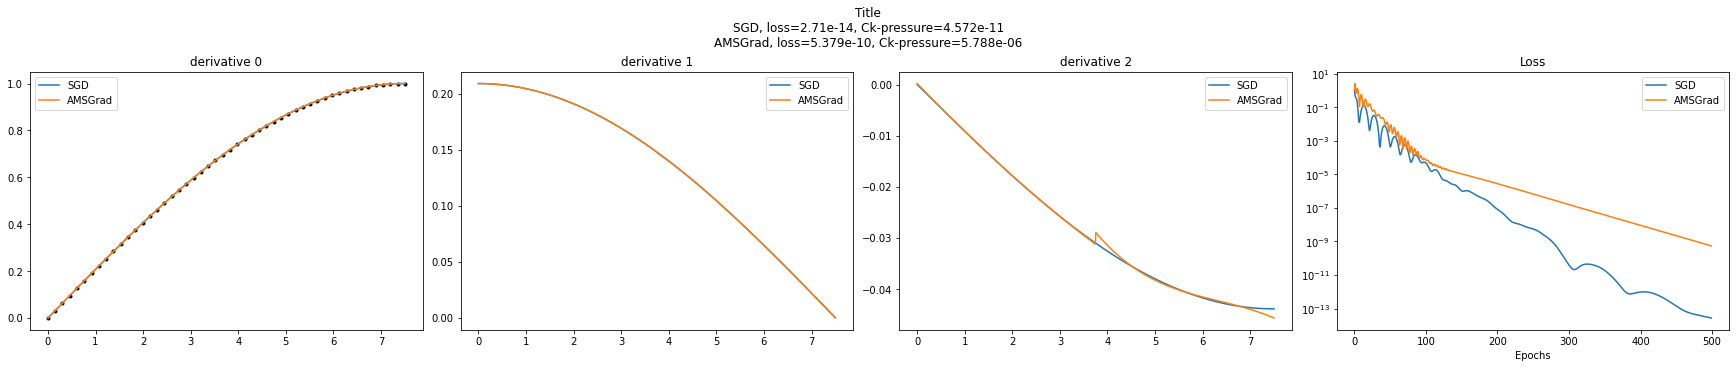

c:\users\pc\documents\fh\ki-net git\mloptimizedcam\venv\lib\site-packages\numpy\ma\core.py:6852: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


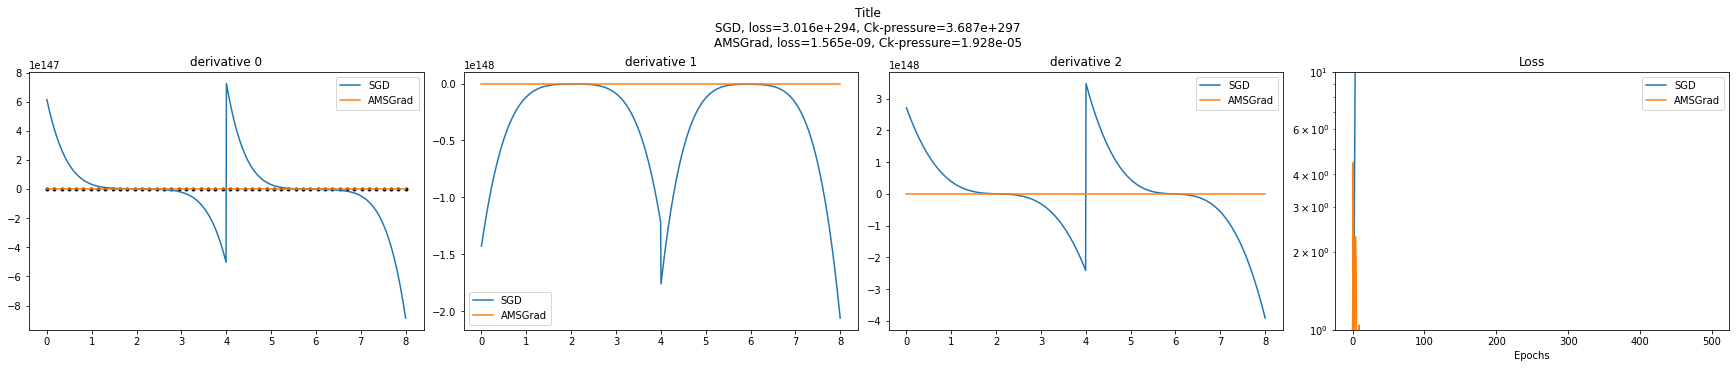

In [24]:
for i in np.arange(7, 9, 0.5):
    fit_and_plot_optimizer_results(i * data_x_norm, data_y_norm, lambd=1, p_num=2, ep=500, initialize_l2_fit=False, overlap_segments=0.4,
                                 shift_polynomial_centers='mean', split_uniform='True')

### Discussion
Also with two polynomials, SGD is able to converge on twice the input interval x-range compared to shifting to the left boundary point.

## Convergence for increasing x input range - Analyze convergence based on loss curves
### 1 Polynomial - $\lambda = 1$

TensorFlow: Number of recognized GPUs:  0
Fitting took 3.0365660190582275 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.115999221801758 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 2.956003189086914 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.0786712169647217 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.2002060413360596 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 2.9027693271636963 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 2.81600022315979 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 2.916039228439331 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.1058337688446045 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.016164541244507 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 2.873142957687378 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.171142339706421 secondsloss=0.000213226epoch=270

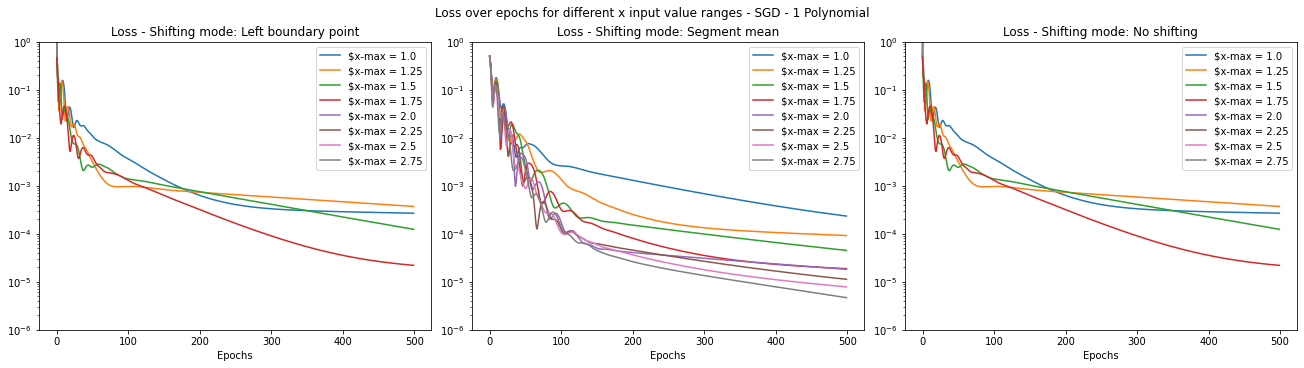

In [12]:
plot_loss_for_different_x_input_ranges(title="Loss over epochs for different x input value ranges - SGD - 1 Polynomial", n=1, AMSGrad=False)

TensorFlow: Number of recognized GPUs:  0
Fitting took 3.1489975452423096 secondsoss=0.000353592epoch=410, loss=0.000288586epoch=450, loss=0.000233576epoch=490, loss=0.000187602
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.177199125289917 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.317570447921753 secondsloss=0.000353592epoch=410, loss=0.000288586epoch=450, loss=0.000233576epoch=480, loss=0.000198306
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.116570234298706 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.277053117752075 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.432114362716675 seconds
TensorFlow: Number of recognized GPUs:  0
poch=460, loss=2.62339e-05Fitting took 3.0375843048095703 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.2730977535247803 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 3.2680952548980713 seconds
TensorFlow: Number of recognized GPUs:  0
Fittin

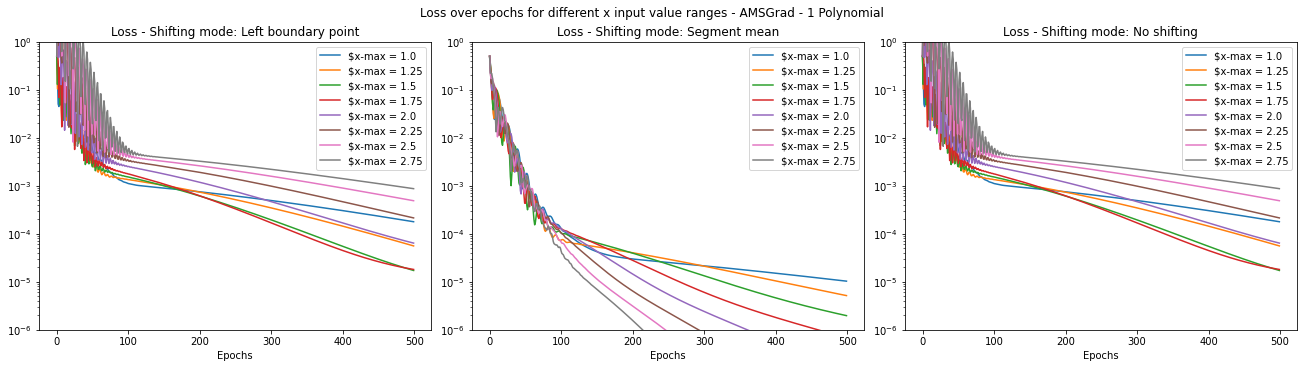

In [13]:
plot_loss_for_different_x_input_ranges(title="Loss over epochs for different x input value ranges - AMSGrad - 1 Polynomial", n=1, AMSGrad=True)

### >1 Polynomial - Decreasing $\lambda$

TensorFlow: Number of recognized GPUs:  0
Fitting took 5.399415969848633 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.253422737121582 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.296126127243042 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.340285539627075 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.187982559204102 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.406594514846802 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.3647496700286865 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.383449554443359 seconds
TensorFlow: Number of recognized GPUs:  0
86e+289epoch=200, loss= infepoch=230, loss= infepoch=250, loss= infepoch=270, loss= infepoch=290, loss= infepoch=310, loss= infepoch=340, loss= infepoch=360, loss= infepoch=390, loss= nanepoch=420, loss= nanepoch=440, loss= nanepoch=470, loss= nanFitting took 5.283580541610718 seconds
TensorFlow: Number of r

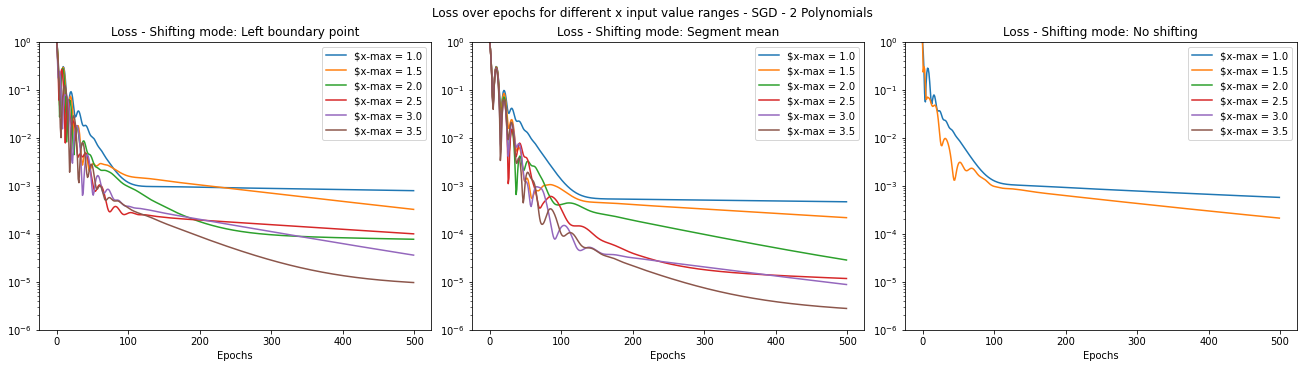

In [7]:
plot_loss_for_different_x_input_ranges(np.arange(1, 4, 0.5), title="Loss over epochs for different x input value ranges - SGD - 2 Polynomials", n=2, AMSGrad=False)

TensorFlow: Number of recognized GPUs:  0
och=320, loss=0.00246359epoch=340, loss=0.00222899epoch=360, loss=0.00201674epoch=380, loss=0.00182472epoch=400, loss=0.001651epoch=420, loss=0.00149384epoch=440, loss=0.00135165epoch=460, loss=0.00122301epoch=480, loss=0.00110663Fitting took 15.16225004196167 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 15.494570255279541 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 15.688138246536255 seconds0.0179333epoch=70, loss=0.0132887epoch=90, loss=0.00957053epoch=110, loss=0.00723922epoch=130, loss=0.00545926epoch=150, loss=0.0041307epoch=170, loss=0.00316305epoch=190, loss=0.00244615epoch=210, loss=0.00191669epoch=230, loss=0.00152612epoch=250, loss=0.00123732epoch=270, loss=0.00102363epoch=290, loss=0.000865285epoch=310, loss=0.000747698epoch=330, loss=0.000660145epoch=350, loss=0.00059472epoch=370, loss=0.000545603epoch=390, loss=0.000508504epoch=410, loss=0.000480266epoch=430, loss=0.000458562epoch=450, loss=0.00

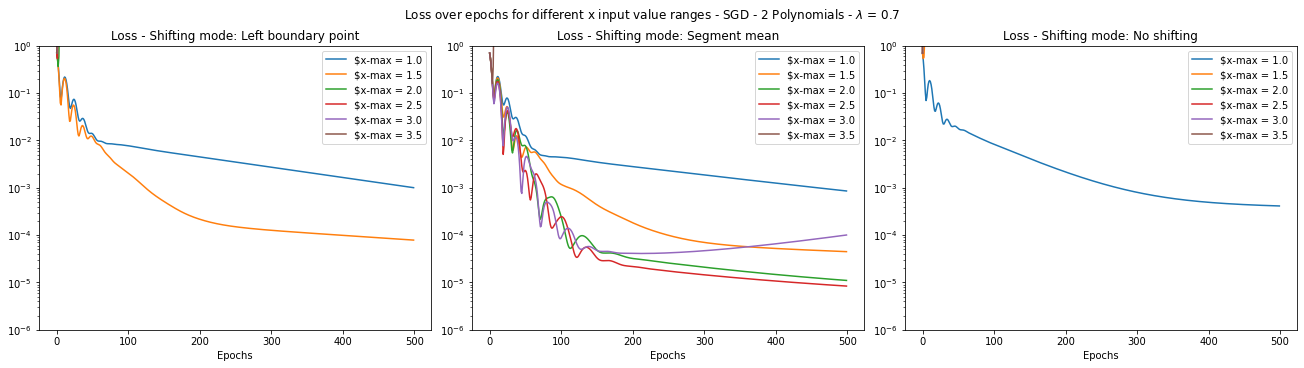

In [8]:
plot_loss_for_different_x_input_ranges(np.arange(1, 4, 0.5), title="Loss over epochs for different x input value ranges - SGD - 2 Polynomials - $\lambda$ = 0.7", n=2, AMSGrad=False, lambd=0.7)

TensorFlow: Number of recognized GPUs:  0
poch=360, loss=0.00234163epoch=380, loss=0.00217979epoch=400, loss=0.00202914epoch=420, loss=0.00188891epoch=440, loss=0.00175838epoch=460, loss=0.00163688epoch=480, loss=0.00152378Fitting took 14.710087537765503 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 14.88755750656128 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 14.74188494682312 secondsoss=0.00267414epoch=230, loss=0.00220944epoch=250, loss=0.00183679epoch=270, loss=0.00153768epoch=290, loss=0.00129755epoch=310, loss=0.00110471epoch=330, loss=0.000949753epoch=350, loss=0.00082516epoch=370, loss=0.000724904epoch=390, loss=0.000644154epoch=410, loss=0.000579038epoch=430, loss=0.000526455epoch=450, loss=0.000483917epoch=470, loss=0.000449433epoch=490, loss=0.000421404
TensorFlow: Number of recognized GPUs:  0
Fitting took 14.7408127784729 seconds loss=0.000111974epoch=390, loss=0.000106101epoch=410, loss=0.00010117epoch=430, loss=9.68822e-05epoch=450, lo

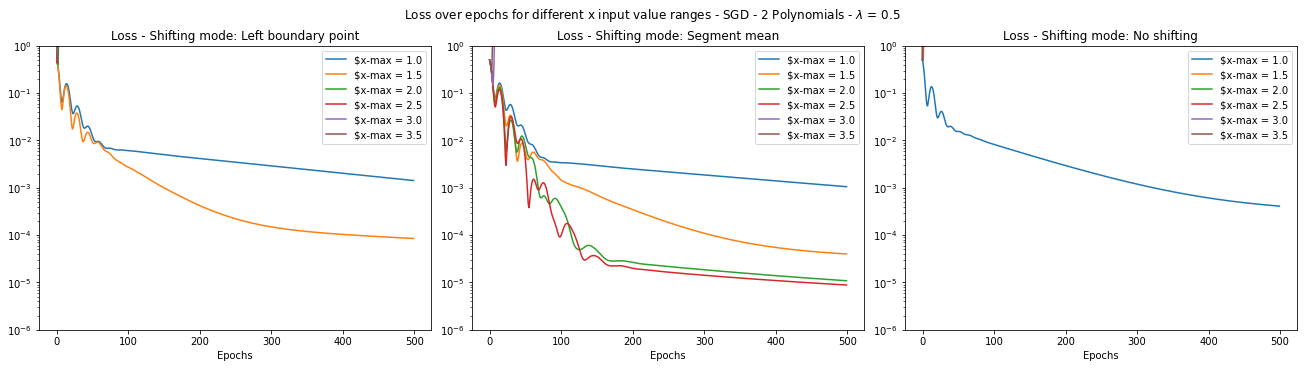

In [9]:
plot_loss_for_different_x_input_ranges(np.arange(1, 4, 0.5), title="Loss over epochs for different x input value ranges - SGD - 2 Polynomials - $\lambda$ = 0.5", n=2, AMSGrad=False, lambd=0.5)

TensorFlow: Number of recognized GPUs:  0
ch=60, loss=0.0199331epoch=80, loss=0.0116902epoch=100, loss=0.0083079epoch=120, loss=0.00679923epoch=140, loss=0.00603113epoch=160, loss=0.00558121epoch=180, loss=0.0052591epoch=200, loss=0.00498916epoch=220, loss=0.00474406epoch=240, loss=0.00451428epoch=260, loss=0.00429652epoch=280, loss=0.00408949epoch=300, loss=0.0038925epoch=320, loss=0.00370503epoch=340, loss=0.00352661epoch=360, loss=0.00335681epoch=380, loss=0.00319522epoch=400, loss=0.00304143epoch=420, loss=0.00289507epoch=440, loss=0.00275578epoch=460, loss=0.00262323epoch=480, loss=0.00249707Fitting took 27.811659812927246 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 27.523404121398926 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 27.479783058166504 secondsss=0.00152532epoch=390, loss=0.00134966epoch=410, loss=0.00120139epoch=430, loss=0.00107615epoch=450, loss=0.00097031epoch=470, loss=0.000880784epoch=490, loss=0.00080499
TensorFlow: Number of 

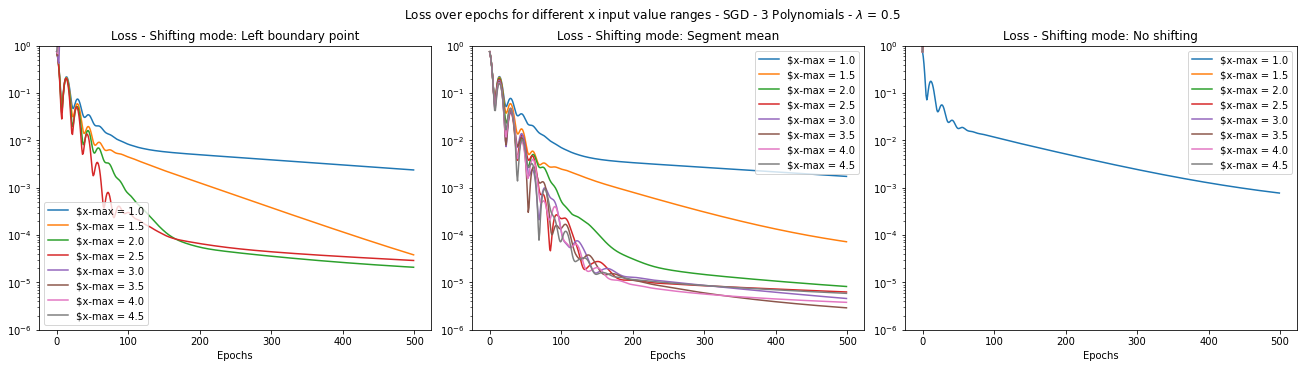

In [11]:
plot_loss_for_different_x_input_ranges(np.arange(1, 5, 0.5), title="Loss over epochs for different x input value ranges - SGD - 3 Polynomials - $\lambda$ = 0.5", n=3, AMSGrad=False, lambd=0.5)

TensorFlow: Number of recognized GPUs:  0
och=160, loss=0.0122078epoch=180, loss=0.0112285epoch=200, loss=0.0103527epoch=220, loss=0.00956877epoch=240, loss=0.0088666epoch=260, loss=0.00823718epoch=280, loss=0.00767247epoch=300, loss=0.00716536epoch=320, loss=0.00670949epoch=340, loss=0.00629924epoch=360, loss=0.00592959epoch=380, loss=0.0055961epoch=400, loss=0.00529481epoch=420, loss=0.00502221epoch=440, loss=0.00477517epoch=460, loss=0.00455092epoch=480, loss=0.00434698Fitting took 59.56448173522949 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 60.25585675239563 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 61.8825249671936 secondsloss=0.00923553epoch=210, loss=0.00879371epoch=230, loss=0.0083785epoch=250, loss=0.0079868epoch=270, loss=0.00761627epoch=290, loss=0.00726511epoch=310, loss=0.00693187epoch=330, loss=0.00661536epoch=350, loss=0.00631456epoch=370, loss=0.00602856epoch=390, loss=0.00575656epoch=410, loss=0.00549782epoch=430, loss=0.0052516

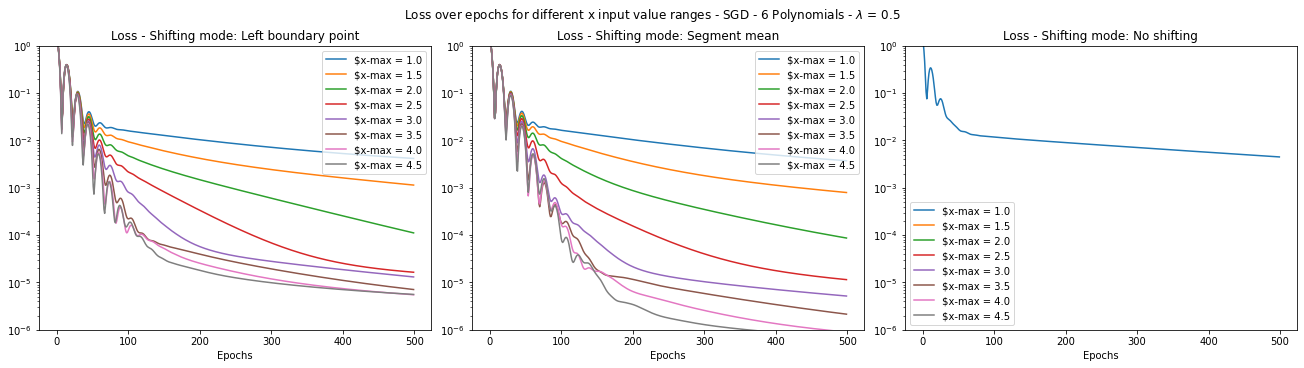

In [12]:
plot_loss_for_different_x_input_ranges(np.arange(1, 5, 0.5), title="Loss over epochs for different x input value ranges - SGD - 6 Polynomials - $\lambda$ = 0.5", n=6, AMSGrad=False, lambd=0.5)

TensorFlow: Number of recognized GPUs:  0
Fitting took 5.7255613803863525 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.73634934425354 seconds loss=4.31938e-05epoch=220, loss=2.74567e-05epoch=240, loss=1.82273e-05epoch=260, loss=1.27998e-05epoch=280, loss=9.52976e-06epoch=300, loss=7.46302e-06epoch=320, loss=6.06714e-06epoch=350, loss=4.64077e-06epoch=370, loss=3.94153e-06epoch=390, loss=3.36847e-06epoch=420, loss=2.67882e-06epoch=450, loss=2.14292e-06epoch=470, loss=1.85332e-06epoch=490, loss=1.6087e-06
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.7393105030059814 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.942512512207031 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.971307754516602 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 5.867666721343994 secondsloss=5.9896e-05epoch=420, loss=5.59263e-05epoch=440, loss=5.34783e-05epoch=460, loss=5.11846e-05epoch=480, loss=4.90403e-05
TensorFlow: Number of r

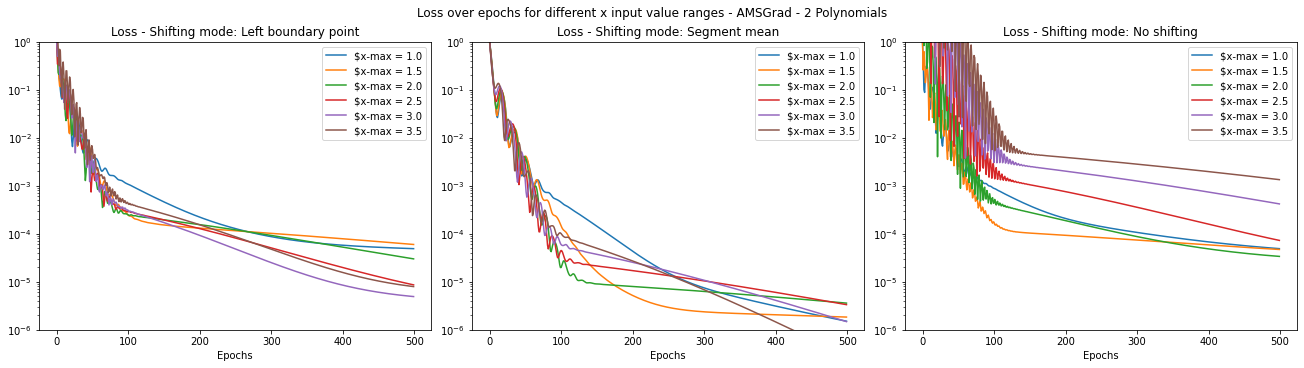

In [13]:
plot_loss_for_different_x_input_ranges(np.arange(1, 4, 0.5), title="Loss over epochs for different x input value ranges - AMSGrad - 2 Polynomials", n=2, AMSGrad=True)

TensorFlow: Number of recognized GPUs:  0
Fitting took 16.19881558418274 secondss=0.00135192epoch=130, loss=0.00110889epoch=150, loss=0.00100628epoch=170, loss=0.000942737epoch=190, loss=0.000888251epoch=210, loss=0.00083594epoch=230, loss=0.000784807epoch=250, loss=0.000734981epoch=270, loss=0.000686701epoch=290, loss=0.000640166epoch=310, loss=0.000595527epoch=330, loss=0.000552892epoch=350, loss=0.000512335epoch=370, loss=0.000473894epoch=390, loss=0.000437583epoch=410, loss=0.000403392epoch=430, loss=0.000371293epoch=450, loss=0.000341241epoch=470, loss=0.000313178epoch=490, loss=0.000287038
TensorFlow: Number of recognized GPUs:  0
Fitting took 16.329041957855225 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 16.250728845596313 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 16.485100030899048 seconds
TensorFlow: Number of recognized GPUs:  0
poch=380, loss=5.32941e-05epoch=400, loss=4.7941e-05epoch=420, loss=4.31156e-05epoch=440, loss=3.87801e-05epo

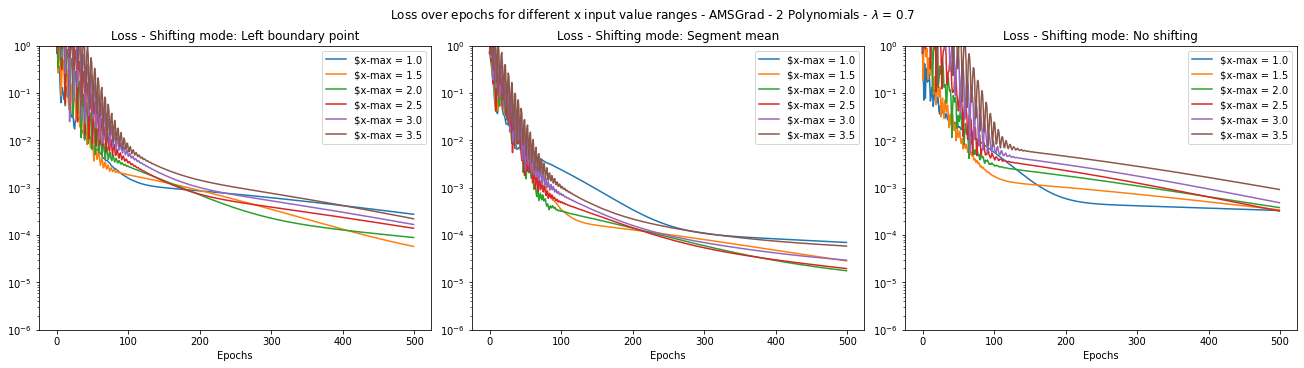

In [14]:
plot_loss_for_different_x_input_ranges(np.arange(1, 4, 0.5), title="Loss over epochs for different x input value ranges - AMSGrad - 2 Polynomials - $\lambda$ = 0.7", n=2, AMSGrad=True, lambd=0.7)

TensorFlow: Number of recognized GPUs:  0
poch=240, loss=0.00089532epoch=260, loss=0.000862623epoch=280, loss=0.000830096epoch=300, loss=0.000797862epoch=320, loss=0.000766032epoch=340, loss=0.000734703epoch=360, loss=0.000703958epoch=380, loss=0.000673867epoch=400, loss=0.000644488epoch=420, loss=0.00061587epoch=440, loss=0.000588052epoch=460, loss=0.000561064epoch=480, loss=0.00053493Fitting took 16.408541202545166 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 17.025702476501465 secondsss=0.00182054epoch=190, loss=0.00149683epoch=210, loss=0.00122096epoch=230, loss=0.000989427epoch=250, loss=0.000797773epoch=270, loss=0.000641103epoch=290, loss=0.00051449epoch=310, loss=0.000413234epoch=330, loss=0.00033303epoch=350, loss=0.000270055epoch=370, loss=0.000220995epoch=390, loss=0.000183038epoch=410, loss=0.000153846epoch=430, loss=0.000131498epoch=450, loss=0.000114446epoch=470, loss=0.000101453epoch=490, loss=9.15467e-05
TensorFlow: Number of recognized GPUs:  0
och=20

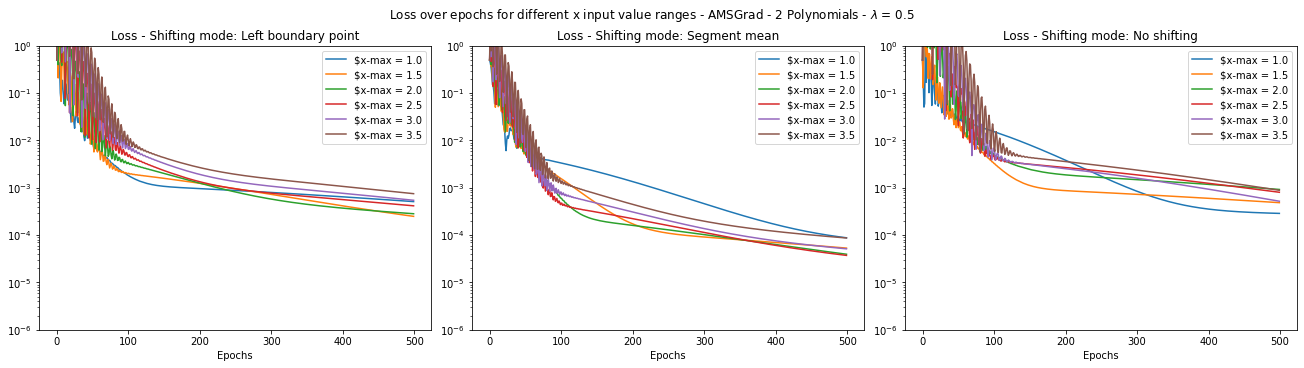

In [15]:
plot_loss_for_different_x_input_ranges(np.arange(1, 4, 0.5), title="Loss over epochs for different x input value ranges - AMSGrad - 2 Polynomials - $\lambda$ = 0.5", n=2, AMSGrad=True, lambd=0.5)

TensorFlow: Number of recognized GPUs:  0
Fitting took 27.73349165916443 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 28.468425989151 seconds
TensorFlow: Number of recognized GPUs:  0
ch=120, loss=0.0125359epoch=140, loss=0.00972643epoch=160, loss=0.00741356epoch=180, loss=0.00556143epoch=200, loss=0.0041137epoch=220, loss=0.00300645epoch=240, loss=0.00217626epoch=260, loss=0.00156505epoch=280, loss=0.00112257epoch=300, loss=0.000807208epoch=320, loss=0.000585668epoch=340, loss=0.000432094epoch=360, loss=0.000326912epoch=380, loss=0.000255633epoch=400, loss=0.000207749epoch=420, loss=0.000175782epoch=440, loss=0.000154498epoch=460, loss=0.000140295epoch=480, loss=0.000130728Fitting took 28.725698471069336 seconds
TensorFlow: Number of recognized GPUs:  0
och=100, loss=0.00027472epoch=120, loss=0.000194378epoch=140, loss=0.000445443epoch=160, loss=0.00013686epoch=180, loss=0.000110653epoch=200, loss=8.95834e-05epoch=220, loss=7.96896e-05epoch=240, loss=7.32377e-05epoch

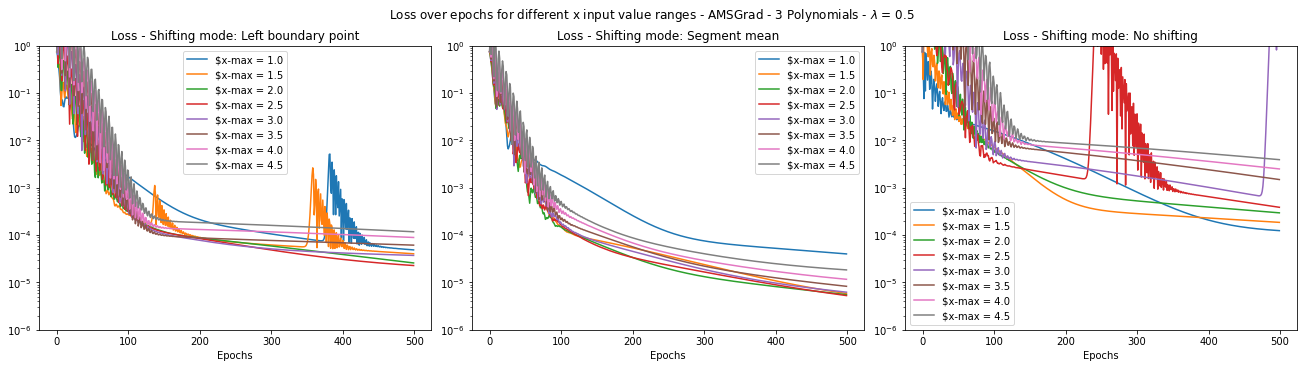

In [16]:
plot_loss_for_different_x_input_ranges(np.arange(1, 5, 0.5), title="Loss over epochs for different x input value ranges - AMSGrad - 3 Polynomials - $\lambda$ = 0.5", n=3, AMSGrad=True, lambd=0.5)

TensorFlow: Number of recognized GPUs:  0
Fitting took 61.582486629486084 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 63.41153073310852 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 62.839481830596924 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 63.42486572265625 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 64.01630091667175 seconds
TensorFlow: Number of recognized GPUs:  0
och=120, loss=0.00541922epoch=140, loss=0.0043473epoch=160, loss=0.00353813epoch=180, loss=0.00286789epoch=200, loss=0.00231008epoch=220, loss=0.00185245epoch=240, loss=0.00148253epoch=260, loss=0.0011874epoch=280, loss=0.000954578epoch=300, loss=0.000772635epoch=320, loss=0.000631521epoch=340, loss=0.000522662epoch=360, loss=0.000438934epoch=380, loss=0.000374545epoch=400, loss=0.000324876epoch=420, loss=0.000286308epoch=440, loss=0.000256047epoch=460, loss=0.000231968epoch=480, loss=0.000212472Fitting took 62.57360124588013 seconds
TensorFlow:

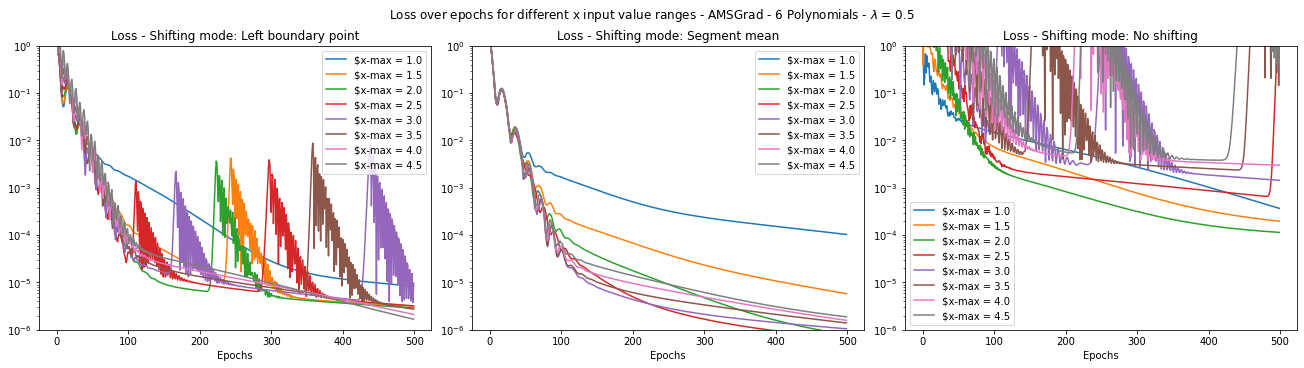

In [17]:
plot_loss_for_different_x_input_ranges(np.arange(1, 5, 0.5), title="Loss over epochs for different x input value ranges - AMSGrad - 6 Polynomials - $\lambda$ = 0.5", n=6, AMSGrad=True, lambd=0.5)

TensorFlow: Number of recognized GPUs:  0
Fitting took 16.738653659820557 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 16.779598236083984 seconds0.0107788epoch=50, loss=0.00287461epoch=70, loss=0.002201epoch=90, loss=0.00197135epoch=110, loss=0.00188654epoch=130, loss=0.00181078epoch=150, loss=0.00173293epoch=170, loss=0.00165412epoch=190, loss=0.00157487epoch=210, loss=0.00149586epoch=230, loss=0.00141767epoch=250, loss=0.00134078epoch=270, loss=0.00126559epoch=290, loss=0.00119244epoch=310, loss=0.00112159epoch=330, loss=0.00105324epoch=350, loss=0.000987536epoch=370, loss=0.000924602epoch=390, loss=0.000864506epoch=410, loss=0.000807286epoch=430, loss=0.000752951epoch=450, loss=0.000701488epoch=470, loss=0.000652858epoch=490, loss=0.00060701
TensorFlow: Number of recognized GPUs:  0
Fitting took 16.865599393844604 secondsss=0.00369491epoch=270, loss=0.00324626epoch=290, loss=0.00284142epoch=310, loss=0.00247867epoch=330, loss=0.00215572epoch=350, loss=0.00186993epo

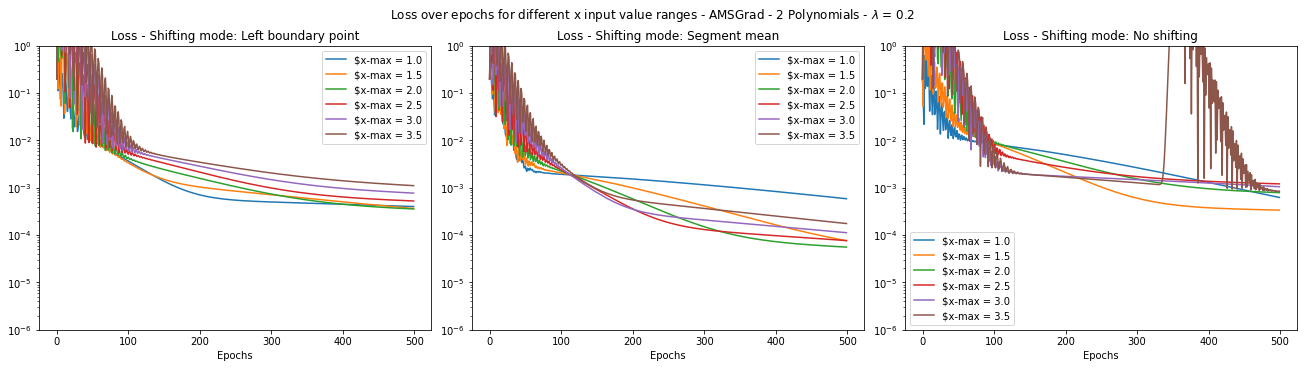

In [18]:
plot_loss_for_different_x_input_ranges(np.arange(1, 4, 0.5), title="Loss over epochs for different x input value ranges - AMSGrad - 2 Polynomials - $\lambda$ = 0.2", n=2, AMSGrad=True, lambd=0.2)

### 2 Polynomials - $\lambda = 0.5$ - Increase $k$ (of requested continuity class $C^k$)

TensorFlow: Number of recognized GPUs:  0
Fitting took 8.99876594543457 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 9.7003915309906 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 9.271005392074585 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 9.010175943374634 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 9.238612651824951 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 9.402670860290527 secondsloss=0.00036475epoch=410, loss=0.00035346epoch=430, loss=0.000346146epoch=450, loss=0.000338997epoch=480, loss=0.000328572
TensorFlow: Number of recognized GPUs:  0
Fitting took 13.25110387802124 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 10.343997716903687 secondsoss=0.000169575epoch=460, loss=0.000164222epoch=490, loss=0.00015905
TensorFlow: Number of recognized GPUs:  0
Fitting took 9.387999534606934 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 9.124011993408203 seconds
Te

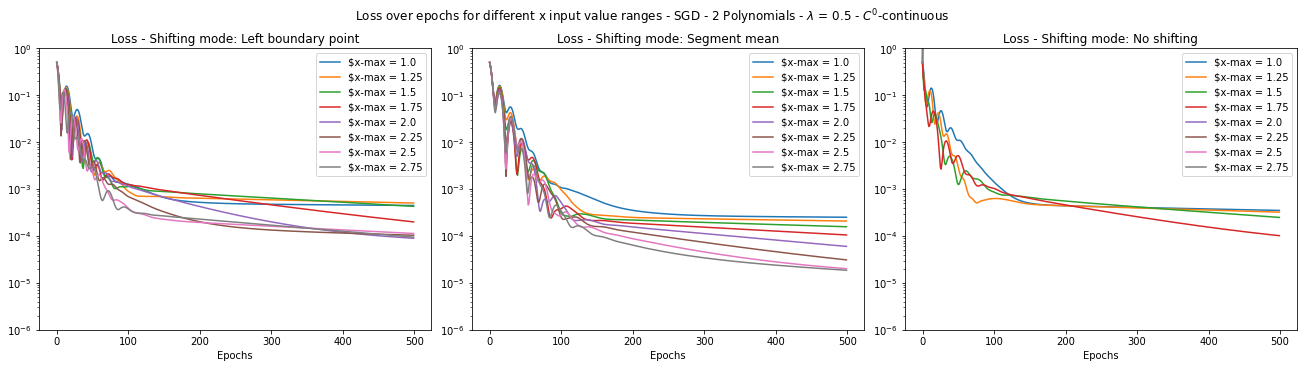

In [6]:
plot_loss_for_different_x_input_ranges(np.arange(1, 3, 0.25), title="Loss over epochs for different x input value ranges - SGD - 2 Polynomials - $\lambda$ = 0.5 - $C^0$-continuous", n=2, AMSGrad=False, lambd=0.5, ck=0)

TensorFlow: Number of recognized GPUs:  0
Fitting took 11.517763137817383 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 11.665679931640625 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 11.328001499176025 seconds
TensorFlow: Number of recognized GPUs:  0
poch=300, loss=0.000513727epoch=320, loss=0.000416433epoch=340, loss=0.000338497epoch=360, loss=0.000276042epoch=380, loss=0.000225969epoch=400, loss=0.000185801epoch=420, loss=0.000153555epoch=440, loss=0.000127649epoch=460, loss=0.000106814epoch=480, loss=9.00392e-05Fitting took 11.420002222061157 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 11.666047096252441 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 11.514002084732056 secondsoss=0.000240698
TensorFlow: Number of recognized GPUs:  0
Fitting took 11.594632863998413 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 11.433604717254639 secondss=0.0014031epoch=120, loss=0.00105387epoch=140, loss=0.000795

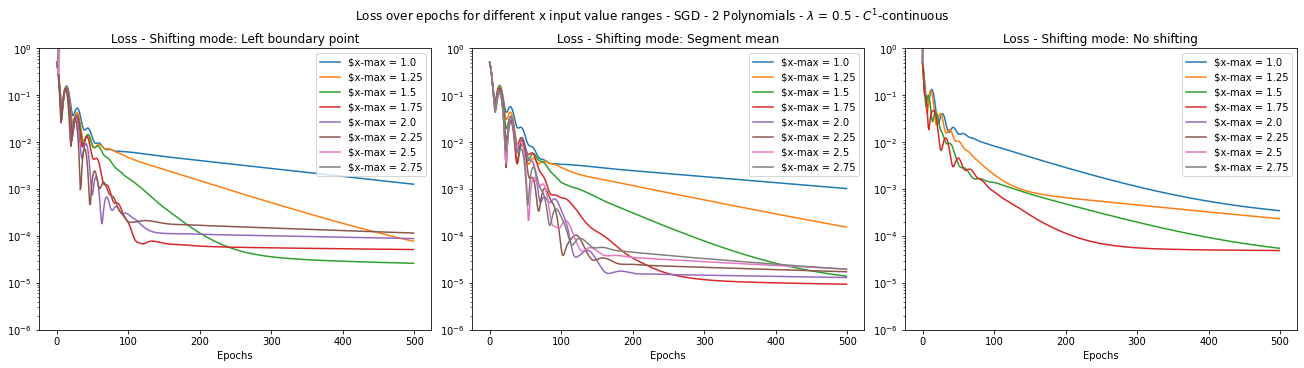

In [7]:
plot_loss_for_different_x_input_ranges(np.arange(1, 3, 0.25), title="Loss over epochs for different x input value ranges - SGD - 2 Polynomials - $\lambda$ = 0.5 - $C^1$-continuous", n=2, AMSGrad=False, lambd=0.5, ck=1)

TensorFlow: Number of recognized GPUs:  0
poch=360, loss=0.00234163epoch=380, loss=0.00217979epoch=400, loss=0.00202914epoch=420, loss=0.00188891epoch=440, loss=0.00175838epoch=460, loss=0.00163688epoch=480, loss=0.00152378Fitting took 14.8476722240448 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 14.922202825546265 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 15.246574401855469 secondsss=0.00267414epoch=230, loss=0.00220944epoch=250, loss=0.00183679epoch=270, loss=0.00153768epoch=290, loss=0.00129755epoch=310, loss=0.00110471epoch=330, loss=0.000949753epoch=350, loss=0.00082516epoch=370, loss=0.000724904epoch=390, loss=0.000644154epoch=410, loss=0.000579038epoch=430, loss=0.000526455epoch=450, loss=0.000483917epoch=470, loss=0.000449433epoch=490, loss=0.000421404
TensorFlow: Number of recognized GPUs:  0
Fitting took 14.682564973831177 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 14.90364122390747 secondsloss=0.000276772epoch=450, l

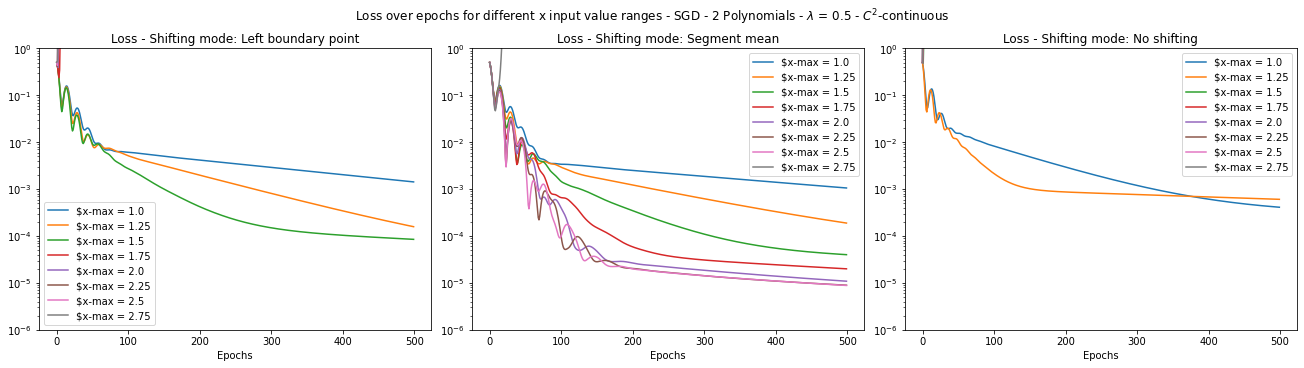

In [8]:
plot_loss_for_different_x_input_ranges(np.arange(1, 3, 0.25), title="Loss over epochs for different x input value ranges - SGD - 2 Polynomials - $\lambda$ = 0.5 - $C^2$-continuous", n=2, AMSGrad=False, lambd=0.5, ck=2)

TensorFlow: Number of recognized GPUs:  0
poch=240, loss=0.00089532epoch=260, loss=0.000862623epoch=280, loss=0.000830096epoch=300, loss=0.000797862epoch=320, loss=0.000766032epoch=340, loss=0.000734703epoch=360, loss=0.000703958epoch=380, loss=0.000673867epoch=400, loss=0.000644488epoch=420, loss=0.00061587epoch=440, loss=0.000588052epoch=460, loss=0.000561064epoch=480, loss=0.00053493Fitting took 14.983528852462769 seconds
TensorFlow: Number of recognized GPUs:  0
Fitting took 15.145076990127563 secondsss=0.00182054epoch=190, loss=0.00149683epoch=210, loss=0.00122096epoch=230, loss=0.000989427epoch=250, loss=0.000797773epoch=270, loss=0.000641103epoch=290, loss=0.00051449epoch=310, loss=0.000413234epoch=330, loss=0.00033303epoch=350, loss=0.000270055epoch=370, loss=0.000220995epoch=390, loss=0.000183038epoch=410, loss=0.000153846epoch=430, loss=0.000131498epoch=450, loss=0.000114446epoch=470, loss=0.000101453epoch=490, loss=9.15467e-05
TensorFlow: Number of recognized GPUs:  0
och=20

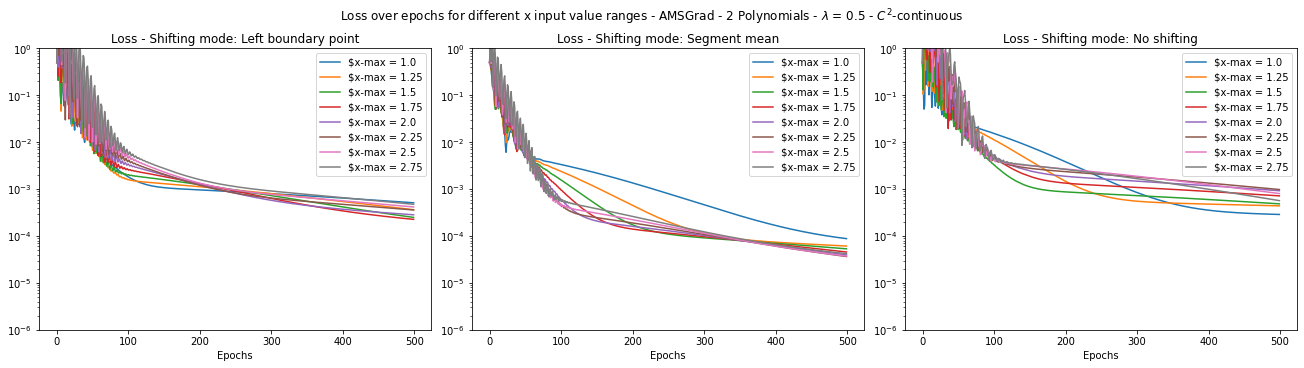

In [9]:
plot_loss_for_different_x_input_ranges(np.arange(1, 3, 0.25), title="Loss over epochs for different x input value ranges - AMSGrad - 2 Polynomials - $\lambda$ = 0.5 - $C^2$-continuous", n=2, AMSGrad=True, lambd=0.5, ck=2)

### Discussion

Experiments show that SGD optimization has a "radius of convergence" around the polynomial center.
With $\lambda = 1$ this radius is about ~1.75 to both sides of the polynomial center.
This leaves us with a "usable" x-range of:
- ~1.75 without shifting of polynomial centers in total for all segments
- ~1.75 per segment for shifting mode "left boundary point", since only the right side of radius is usable
- ~3.5 per segment for shifting mode "mean", since both sides of radius are usable

If we take an x interval of [0, 2], as an example, and divide it into two equally sized segments:
- Without shifting polynomial centers, the second polynomial will diverge, since points lie outside the 1.75 radius
- With shifting to the left boundary point, both segments will converge
- With shifting to the mean of the segment, both segments will converge

Adding more optimization targets than just the approximation target decreases the "radius of convergence".
If we add the $C^k$-optimization target:
 - Increasing $k$ of continuity class requirement $C^k$ reduces the "radius of convergence".
   While we can still fit an x interval of [0, 2] divided it into two equally sized segments with $\lambda=0.5$
   shifting to the left boundary point when going for $C^1$-continuity, optimization diverges for $C^2$-continuity.
   This is because gradient magnitudes rise if we increase $k$.
   See next point.
 - Decreasing $\lambda$ decreases the "radius of convergence".
   Decreasing $\lambda$ increases $C^k$ optimization target priority and therefore loss levels and gradient magnitudes.
   With $\lambda = 0.5$, for $C^2$-continuity, the "radius of convergence" is reduced to just under $~1$,
   which makes an x interval of [0, 2] divided it into two equally sized segments diverge
   for shifting to the left boundary point and without shifting.
   However, since shifting to the mean of the segment makes both sides around the polynomial center "available"
   for optimization, it is still able to converge.

Because of these benefits and because shifting to the mean of the segment also shows lower remaining loss levels compared to other shifting methods in our tests,
shifting polynomial centers to the mean of the respective segment is the way to go here.